# PubMed PaperRank Analysis

---

This notebook contains the analysis of the PubMed PaperRank dataset.

For more information, see the PaperRank GitHub Page: [[GitHub]](http://github.com/rukmal/PaperRank)

**IMPORTANT**

> *Note: If you are not a collaborator, first open the notebook in playground mode (*File -> Open in playground mode*).*

To use the [Model Explorer](#scrollTo=q8Nj_dy2Mdd1), you need to run a portion of this notebook. Speficially, the data loading and model training sections.

Run the following to use the Model Explorer without running unnecessary computations:

- Go to [this](#scrollTo=ULVJyFvyRps6) block, and select *Run before* (`⌘/Ctrl+F8` or *Runtime -> Run before*)
  - **NOTE:** You may have to login to your Google Account [here](#scrollTo=njsus7GqJic6).

## Table of Contents

>[PubMed PaperRank Analysis](#scrollTo=8jGksJd5QnM4)

>>[Table of Contents](#scrollTo=y_sS4--HKREg)

>>[Notebook Setup](#scrollTo=ijJJ7LbhHzL4)

>>>[Package Installation](#scrollTo=NGB-tRhhJQY6)

>>>[Jupyter Configuration](#scrollTo=5XWRs08Kb-mm)

>>>[Module Imports](#scrollTo=l0cEoNCCIsv3)

>>>[Authentication](#scrollTo=5DqUD3meJYET)

>>>[PubMed PaperRank Data Load](#scrollTo=0qvzoVp7IZrk)

>>>[Data Cleaning](#scrollTo=cGgVt2oHNM9V)

>>>[Descriptive Statistics](#scrollTo=53zc_iYwQLQF)

>>>[Plot Setup](#scrollTo=nWIqj4Vgzc9P)

>>>[Publication Metadata](#scrollTo=3X5YcPOfdVvt)

>>>[Mixture Model Visualization](#scrollTo=GDNo0jJ8vgin)

>>>[Model Saving and Loading](#scrollTo=5O3VDRq13qDI)

>>>[Trust Score Export](#scrollTo=tntMKAx2Gj1d)

>>>[Model Output Cleaning](#scrollTo=u7FjM0WE3HGv)

>>>[Model Parameter Processing](#scrollTo=zm_SFsleGRhY)

>>>[PubMed Search API](#scrollTo=7z9RXll6xpTy)

>>>[DataFrame Formatting](#scrollTo=cpXEPs8CBpEo)

>>>[LaTeX Formatting](#scrollTo=gfcP-eN75iPY)

>>>[Environment Setup](#scrollTo=9RDn2H9zJhZc)

>>[Distribution Analysis](#scrollTo=ULVJyFvyRps6)

>>>[Descriptive Statistics](#scrollTo=ZFl2_pJPZ8Qy)

>>>[Distribution Plots](#scrollTo=CXoiFt3TbnyA)

>>>>[Box Plot](#scrollTo=WuEpFd1kyfWF)

>>>>[Histogram](#scrollTo=uxRmRGXA5J6B)

>>>>[Scatter Plot](#scrollTo=0RaFfvgv69l-)

>>[Frequency Distribution Analysis](#scrollTo=Ji5zfEe5F-ej)

>>>[Max PaperRank Publication Analysis](#scrollTo=SLnR_DHoQC7u)

>>>[Outlier Analysis](#scrollTo=o2AutSKdYG7F)

>>[Bayesian Gaussian Mixture Model (GMM)](#scrollTo=qw2yKYh2EDOA)

>>[Log Transformation](#scrollTo=EtRxlsj094YG)

>>>[Computation](#scrollTo=rnpKuC6qCO84)

>>>[Descriptive Statistics](#scrollTo=KVACgex7-Ne-)

>>>[Distribution Plots](#scrollTo=4u9LpjOYBHWs)

>>>>[Box Plot](#scrollTo=2kiR79iZBLPV)

>>>>[Histogram](#scrollTo=X7J9reQDBkJu)

>>>>[Scatter Plot](#scrollTo=7x2BultzBy-6)

>>>[Heuristic Convergence Test](#scrollTo=CllXSg5TRri7)

>>>[GMM Model Training](#scrollTo=QOUoEzbaS6Xl)

>>>>[Model Backup](#scrollTo=CffQdp_lpXvx)

>>>[Model Parameters](#scrollTo=heQfQPTUT0gP)

>>>[Model Visualization](#scrollTo=YFWb-Z7bTFdc)

>>[Inverse CDF Transformation](#scrollTo=CKu6xfDx3TFB)

>>>[Computation](#scrollTo=X4w1b019CilJ)

>>>[Descriptive Statistics](#scrollTo=sQ95lbGqCnqc)

>>>[Distribution Plots](#scrollTo=lH9dh7dfC8k0)

>>>>[Box Plot](#scrollTo=J6n-jwB-DBLB)

>>>>[Histogram](#scrollTo=zp4VNTlIDLHy)

>>>>[Scatter Plot](#scrollTo=FCJWdpnUDWZy)

>>>[Heuristic Convergence Test](#scrollTo=L_v6nC3AD6MQ)

>>>[GMM Model Training](#scrollTo=CgjDurHaFlMv)

>>>>[Model Backup](#scrollTo=bQUw0XgxRaYS)

>>>[Model Parameters](#scrollTo=CNDh3ZEZI7AB)

>>>[Model Visualization](#scrollTo=cx8ohZODYBM1)

>>[InvCDF GMM Trust Score](#scrollTo=5ESkLHL_uXHh)

>>>[Model Clusters](#scrollTo=ggsveqUs7ZJ6)

>>>[Baseline Trust](#scrollTo=lEjK1wnh5-Fh)

>>>[Membership Probabilities](#scrollTo=9Gyut32Trr5x)

>>>[Formula Derivation](#scrollTo=dMcnMUJi5pxA)

>>>[Trust Categories](#scrollTo=0zS6-00Ehzt9)

>>>[Trust Score Computation](#scrollTo=pzSdkYb5gGVA)

>>>>[Trust Score Backup](#scrollTo=Kd6Gap2vYTSf)

>>>[Trust Statistics](#scrollTo=wcP1scKcULUo)

>>>[Trust Distribution Plots](#scrollTo=pM4c0ioGR2cI)

>>>>[Histogram](#scrollTo=JijeWhZba0F-)

>>>>[Scatterplot](#scrollTo=nNVvJ_-2a4nD)

>>[K-Means Clustering Model](#scrollTo=yuOxtnAzpeFr)

>>>[Model Training](#scrollTo=MgUgpc-TrCgx)

>>>>[Model Backup](#scrollTo=iqFoB_OMxN4F)

>>>[Model Parameters](#scrollTo=yBeziDu50Vy9)

>>>[Model Visualization](#scrollTo=W6Syae3y-xnD)

>>[InvCDF K-Means Trust Score](#scrollTo=tFb3Hl5qAj2Q)

>>>[Inverse Distance Computation](#scrollTo=I8tZGD5336xV)

>>>[Softmax Function](#scrollTo=FAXMwt_WGIRq)

>>>>[Softmax Backup](#scrollTo=zg3CKa-qNG6D)

>>>[Baseline Trust](#scrollTo=g13mGMiAVoVP)

>>>[Formula Derivation](#scrollTo=UEl0uzD-VuNK)

>>>[Trust Categories](#scrollTo=QTe_Wnc8V1ei)

>>>[Trust Score Computation](#scrollTo=b6lYZ_0hYZG3)

>>>>[Trust Score Backup](#scrollTo=azHgOB3qY25k)

>>>[Trust Statistics](#scrollTo=VoJ7420GkWcv)

>>>[Trust Distribution Plots](#scrollTo=8fxlQ3ZekmCZ)

>>>>[Histogram](#scrollTo=kQZKI0zYkupl)

>>>>[Scatterplot](#scrollTo=2cS6i2-Ik4aw)

>>>[Discussion](#scrollTo=jC_w5rVuTf_7)

>>[InvCDF Gamma Model](#scrollTo=TXTUN07LZ-th)

>>>[Gamma Distribution](#scrollTo=trYENLN9fOqL)

>>>[Gamma Distribution Analysis](#scrollTo=kBWhBTb7kr8e)

>>>>[Distribution Moments](#scrollTo=DF8OOs0rl77X)

>>>>[Behavior Analysis](#scrollTo=p_ewKwGTnDx1)

>>>[Generalized EM Algorithm](#scrollTo=t4qSNZ5Afyl7)

>>>>[Motivation](#scrollTo=exizKrMzsBmH)

>>>>[Variable Definitions](#scrollTo=33p2Bi3EsPTs)

>>>>[Membership Probabilities](#scrollTo=KhNBqAGQsbzg)

>>>>[Mixture Proportions](#scrollTo=9DCVvnMAPRMG)

>>>>[Mixture Distribution Density](#scrollTo=jc0BwvCAPoyu)

>>>>[Log Likelihood](#scrollTo=DUNpYf4fsY63)

>>>>[Complete EM Algorithm](#scrollTo=tkDQdXWVT9Wh)

>>>[Implementation](#scrollTo=guA7RJ46Km8J)

>>>>[Positivity Constraint](#scrollTo=8w56la6pyHPS)

>>>>>[Histogram](#scrollTo=t2CdlvcAyPLG)

>>>>>[Descriptive Statistics](#scrollTo=6k91qnq4zNCg)

>>>>[Density Computation](#scrollTo=6dhpzUg0Se5T)

>>>>[Scaled Density Computation](#scrollTo=EOceEnCVixhk)

>>>>[Membership Probabilities](#scrollTo=8_PB1SWaD85K)

>>>>[Mixture Proportions](#scrollTo=SzcMgK31QGDK)

>>>>[Log Likelihood](#scrollTo=P5RmnL4euQdg)

>>>>[Log Likelihood Maximization](#scrollTo=cIOXTYiZb3bw)

>>>>[EM Initialization](#scrollTo=orM3vxpLt0Jj)

>>>>[Convergence Check](#scrollTo=9LtiWmX7iOTf)

>>>>[Temporary Model Saving](#scrollTo=Y8jLDVKmr0pX)

>>>>[Gamma Mixture EM Algorithm](#scrollTo=Wb4Ol60pr0T8)

>>>[Model Training](#scrollTo=5GKLx_Rse917)

>>>>[Model Training Recovery](#scrollTo=WI0RgtbSpCXo)

>>>>[Model Backup](#scrollTo=zm-3OQmjBgKY)

>>>[Model Parameters](#scrollTo=6PeEmzXhDd0d)

>>>[Model Analysis](#scrollTo=6xcY4GbeHYN1)

>>>[Model Visualization](#scrollTo=MP7mjNGPKBm6)

>>[InvCDF Gamma Trust Score](#scrollTo=QngH-dom0ie5)

>>>[Baseline Trust](#scrollTo=4BwzpZ9x7por)

>>>[Membership Probabilities](#scrollTo=Plx2f12Y7yeu)

>>>[Formula Derivation](#scrollTo=XsIe9cjB8T2R)

>>>[Trust Categories](#scrollTo=jKPDFnyx8Zzy)

>>>[Trust Score Computation](#scrollTo=R7GeNa8K8nWc)

>>>[Trust Score Scaling](#scrollTo=5p1dmam0_Hdy)

>>>>[Trust Score Backup](#scrollTo=0WTr5rT1JA4B)

>>>>[Trust Score Export](#scrollTo=WNR5XiuaL4f6)

>>>[Trust Statistics](#scrollTo=i-SXpQFK9fWA)

>>>[Trust Distribution Plots](#scrollTo=JU5e7Q0R9vNu)

>>>>[Histogram](#scrollTo=YPnqUABr9xvW)

>>>>[Scatterplot](#scrollTo=iWzl4Xx398cl)

>>[PaperRank Model Exploration](#scrollTo=q8Nj_dy2Mdd1)



## Notebook Setup

This section sets up core functionality required for the Jupyter notebook. This includes file loading, parsing and some basic data cleaning. It also contains source code for some helper modules used in the notebook.

This dataset is imported from the `paperrank-data` directory, which is in the same directeory as this notebook on Google Drive. The entire `output/` folder was copied from the PaperRank repository, and simply renamed to `paperrank-data`.

### Package Installation

This section contains logic for installing required packages.

In [0]:
# Installing PyDrive
!pip install -U -q PyDrive

# Installing seaborn (viz library)
!pip install -U -q seaborn

# Installing pubmed-lookup (PubMed query library)
!pip install -U -q pubmed-lookup

### Jupyter Configuration

Suppress warnings.

In [0]:
import warnings

warnings.filterwarnings('ignore')

### Module Imports

This section contains module imports used by this script. The imports are grouped by their corresponding functionality for clarity.

In [0]:
# Google Drive file loading/exporting
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Formatting
from IPython.display import display, HTML

# Data loading
from io import StringIO
import os
import pickle

# Data manipulation
from collections import namedtuple
from scipy import optimize
from scipy.stats import norm
from scipy import stats
import numpy as np
import pandas as pd
import time

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# PubMed data
from pubmed_lookup import PubMedLookup, Publication

# Mixture models
from math import exp, fabs, pi, sqrt
from matplotlib.patches import Ellipse
from sklearn import mixture, cluster

# Search imports
from requests import get
import re

# Rounding error mitigation
from decimal import *

### Authentication

This section contains logic for authenticating the user with Google Drive. Follow the prompts here for Google Drive operations to function correctly.

This functionality is adapted from the official Google Colab guide on handling external data, which can be found [here](https://colab.research.google.com/notebooks/io.ipynb).

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### PubMed PaperRank Data Load

This section contains the logic for loading the `paperrank.csv` file from the `paperrank-data/` folder.

The function below loads and parses a CSV file from Google Drive to a Pandas DataFrame. This functionality is implemented using the `PyDrive` package, whose documentation is [here](https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html).

In [0]:
def loadCSVFile(id: str) -> pd.DataFrame:
  """Function to get and load a CSV file from Google Drive into a
  Pandas `pd.DataFrame` object.
  
  Arguments:
    id {str} -- Google Drive ID of the file to be downloaded. This can be found
                by turning on 'Link Sharing' in Drive, and copying the ID from
                the resulting URL.
  """

  # Getting file from Google Drive
  downloaded_file = drive.CreateFile({'id': id})
  downloaded_file_serialized = StringIO(downloaded_file.GetContentString())
  
  # Parsing StringIO to DataFrame
  csv_parsed = pd.read_csv(downloaded_file_serialized)
  
  print('Read CSV file to Pandas DataFrame with dimensions', csv_parsed.shape)
  
  return csv_parsed

Loading the `paperrank.csv` file from Google Drive.

In [7]:
paperrank_id = '1zYkuS_a7Val6dRR-GpNwouUuMlOVDmT5'

pr_df = loadCSVFile(paperrank_id)

Read CSV file to Pandas DataFrame with dimensions (14483643, 2)


### Data Cleaning

This section contains logic to load data from the `pr_df` DataFrame to `numpy` arrays for faster statistical operations.

In [0]:
# Creating np.array of IDs
pr_id = np.array(pr_df['PubMed ID'], dtype=np.int)

# Creating np.array of PaperRanks
pr_rank = np.array(pr_df['PaperRank'], dtype=np.float)

# Get descending sort index
pr_sort_idx = np.argsort(pr_rank, axis=0)[::-1]

### Descriptive Statistics

The section contains logic to compute basic descriptive statistics for a distribution.

In [0]:
def computeDescriptiveStatistics(data: np.array) -> dict:
  """Function to compute descriptive statistics for a given distribution.
  
  Arguments:
    data {np.array} -- Statistics for computation.
  
  Returns:
    {dict} -- Dictionary with descriptive statistics.
  """

  desc_stats = dict()

  # Computing descriptive stats
  desc_stats['mean'] = np.mean(data)
  desc_stats['sd'] = np.std(data)
  desc_stats['var'] = np.var(data)
  desc_stats['skew'] = stats.skew(data)
  desc_stats['kurtosis'] = stats.kurtosis(data)
  desc_stats['median'] = np.median(data)
  desc_stats['min'] = np.amin(data)
  desc_stats['max'] = np.amax(data)
  desc_stats['range'] = desc_stats['max'] - desc_stats['min']
  desc_stats['N'] = data.size
  
  return desc_stats

This function builds a DataFrame to be displayed with distribution statistics.

In [0]:
def displayDescriptiveStatistics(stats: dict, name: str) -> pd.DataFrame:
  """Function to display descriptive statistics for a distribution.
  
  Arguments:
    stats {dict} -- Dictionary of statistics to be displayed.
    name {name} -- Name of the distribution.
  
  Returns:
    {pd.DataFrame} -- DataFrame to be displayed.
  """
  # Create DataFrame (for display)
  display_df = pd.DataFrame.from_dict([stats.values()])
  display_df = display_df.T

  # Set index and index title
  display_df.index.name = 'Statistic'
  display_df.index = list(stats.keys())
  # Set column names
  display_df.columns = [name]

  return display_df

### Plot Setup

This section contains logic to set up the plot-related things. The first block contains configuration items, and the second contains a funciton to build a subplot for the plots.

In [0]:
# Setting plot style to dark
sns.set_style('darkgrid')

# Setting plot title size to xx-large from large
plt.rcParams['figure.titlesize'] = 'xx-large'

In [0]:
# Defining dimensions
# key: (width, height) [inches]
dims_normal = (11.7, 8.27)
dims_large = (20, 11)

def getSubplot(dimensions: tuple) -> tuple:
  """Function to get a subplot for plotting, formatted to the
  correct dimensions.
  
  Arguments:
    dimensions {tuple} -- Dimensions tuple in the form of (width, height)
                          in inches.
  
  Returns:
    tuple -- PyPlot Figure and Axes for plotting with Seaborn.
  """

  fig, ax = plt.subplots(figsize=dimensions)
  return fig, ax

### Publication Metadata

The following code implements publication metdata downloading from PubMed for a given ID, using the [`pubmed_lookup` package](https://github.com/mfcovington/pubmed-lookup).

In [0]:
def getPublicationMetadata(pmid: str) -> list:
  """Function to get publication metadata from the NCBI PubMed database.
  """
  # Configuration
  base_url = 'http://www.ncbi.nlm.nih.gov/pubmed/'
  email = ''
  
  # Building query URL
  query_url = base_url + pmid
  lookup = PubMedLookup(query_url, email)
  
  # Instantiating publication object
  publication = Publication(lookup)

  # Returning relevant list of metadata
  return [publication.title, publication.authors, publication.year, \
          publication.abstract]

### Mixture Model Visualization

The following code implements plotting functionality for the mixture models.

This function draws ellipses a set number of standard deviations out from the mean.

In [0]:
def drawEllipse(position: np.ndarray, covariance: object, ax: object,
                n_sd: int=2, **kwargs):
  """Draw an ellipse of a distribution on a graph, given its position and
  covariance.
  
  Arguments:
    position {np.ndarray} -- Position of the distribution on the graph.
    covariance {object} -- Covariance of the distribution.
    ax {object} -- Axis the Ellipse will be plotted on.
    
  Keyword Arguments:
    n_sd {int} -- Number of standard deviations to draw. (default: {2})
  """
  
  # Compute width, height and angle depending on covariance type
  if covariance is int:
    # Using covariance_type 'spherical'
    width = 2 * sqrt(covariance)
    height = width
    angle = 0
  if covariance.shape == (2, 2):
    # Using covariance_type 'full' or 'tied'
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
  else:
    # Using covariance_type 'diag'
    width, height = 2 * np.sqrt(covariance)
    angle = 45

  
  # Draw the Ellipse
  for nsig in range(1, n_sd + 1):
    ax.add_patch(Ellipse(xy=position, width=(nsig * width),
                         height=(nsig * height), angle=angle, **kwargs))

This function draws the labeled predictions and then draws ellipses.

In [0]:
def drawMixtureModel(model: mixture.BayesianGaussianMixture, preds: np.ndarray,
                     X: np.ndarray, ax: object, set_title: bool=True,
                     transparency: float=0.4, label: bool=True):
  """Draw a mixture model on a plot, with ellipses over component distribution
  covariances.
  
  Arguments:
    model {mixture.BayesianGaussianMixture} -- Trained mixture model.
    preds {np.ndarray} -- Predictions from the model.
    X {np.ndarray} -- Dataset used to compute predictions.
    ax {object} -- Axes to plot the model.

  Keyword Arguments:
    set_title {bool} -- Flat to toggle plot title with training size.
    transparency {float} -- Transparency factor of ellipses. (default: {0.4})
    label {bool} -- Flag to toggle label printing. (default: {True})
  """
  
  # Check if we plot labels (i.e. colors)
  if label:
     # `s` is point size
    ax.scatter(X[:, 0], X[:, 1], cmap='RdYlGn', c=preds, marker='x', s=1)
  else:
    ax.scatter(X[:, 0], X[:, 1], marker='x')
    
  # Transparency
  w_factor = transparency / model.weights_.max()
  
  # Plot Ellipse for each distribution
  for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
    # Set title
    if set_title:
      title = 'Training size: ' + '{:,}'.format(len(X[:, 0]))
      ax.set_title(title)
    
    # Transparency
    alpha = w * w_factor

    # Draw Ellipse
    drawEllipse(position=pos, covariance=covar, ax=ax, alpha=alpha)

### Model Saving and Loading

**NOTE:** Usage of these functions is limited to collaborators.

This section contains code to save and load the model to Google Drive.

The following ID corresponds to the `model/` folder in the `PaperRank-Analysis/` repository folder.

In [0]:
model_save_folder = '1PIedSkVZw-4BwggplQi4gtUmlQzokliy'

The following function deletes all files in the `model/` folder. It is to be run directly before `saveAllFiles(...)`.

In [0]:
def deleteFiles(files: list):
  """Function to delete given files in the `model/` folder.
  
  Arguments:
    files {list} -- List of files to be deleted.
  """
  
  print('Trying to delete {} files in the `models/` folder'.format(len(files)))
  
  # List all files in the model_save_folder directory
  file_list = drive.ListFile({'q': "'{}' in parents"
                              .format(model_save_folder)}).GetList()

  # counter
  n = 0
  
  for file in file_list:
    # If exists, delete
    try:
      file_idx = files.index(file['title'])  # Exist check
      file.Delete()
      print('Deleting file {0} with ID {1}'.format(file['title'], file['id']))
      n += 1
    except ValueError:
      continue
  
  print('Deleted {} files in `models/` folder'.format(n))

The following function saves all files to the `model/` directory.

In [0]:
def saveVariables(variables: dict):
  """Function to save a list of files (i.e. vars) (pickled) to the
  `model_save_folder` folder on Google Drive. This function can only
  be run by Collaborators.
  
  Arguments:
    variables {dict} -- Dictionary of files ({'name': object}) to be saved.
  """
  
  # Temporary file name
  tmp_filename = 'tmpfile'
  
  # Delete the file if they exist from the folder
  deleteFiles(files=list(variables.keys()))
  
  print('Starting variable upload')
  
  for name, variable in variables.items():
    # Saving to temporary file (option 'w+b' opens and truncates to 0b)
    with open(tmp_filename, mode='w+b') as f:
      pickle.dump(variable, f)
      print('Uploading file with variable {0} of size {1}'
            .format(name, os.stat(tmp_filename).st_size))
      
    # Create Google Drive file, with file name
    uploaded = drive.CreateFile({'title': name,
                                 'parents': [{
                                     'kind': 'drive#fileLink',
                                     'id': model_save_folder
                               }]})
    
    # Add data to file
    uploaded.SetContentFile(tmp_filename)
    
    # Upload file
    uploaded.Upload()
    
    # Delete temporary file
    print('Removing temporary file of {} bytes'
          .format(os.stat(tmp_filename).st_size))
    os.remove(tmp_filename)
    
    # Print results
    print('Uploaded variable to file {0} with ID {1}'
          .format(uploaded['title'], uploaded['id']))
  
  print('Finished uploading {} variables'.format(len(variables)))

The following function loads files from the `models/` folder.

In [0]:
def loadVariable(var_name: str) -> object:
  """Function to load a variable from the `models/` folder.
  
  Arguments:
    var_name {str} -- Variable name to load.
  
  Returns:
    {object} -- Unpickled object from the corresponding file.
  """
  
  # List all files in the model_save_folder directory
  file_list = drive.ListFile({'q': "'{}' in parents"
                              .format(model_save_folder)}).GetList()
  
  print('Found {} files in `models/` directory'.format(len(file_list)))
  
  for file in file_list:
    if file['title'] == var_name:
      print('Loading file {0} with ID {1} of {2} bytes'
            .format(file['title'], file['id'], file['fileSize']))
      file.GetContentFile(var_name)
  
  with open(var_name, mode='r+b') as f:
    var = pickle.load(f)
  
  # Delete temproary file
  print('Removing temporary file of {} bytes'
        .format(os.stat(var_name).st_size))
  os.remove(var_name)
  
  # Return result
  return var

### Trust Score Export

This section contains code to output the trust scores to a given file in Google Drive. Note that these files are saved in `output/` in the `PaperRank-Analysis` directory on Drive.

In [0]:
trust_save_folder = '1aJZUY9PXikPgCeDrDyre-ki544eI5kDG'

In [0]:
def exportTrustScore(data: pd.DataFrame, name: str):
  """Function to export trust scores to a CSV file on Google Drive.
  
  Arguments:
    data {pd.DataFrame} -- Data to be saved.
    name {str} -- Name of the file.
  """
  
  print('Saving {} to VM disk'.format(name))
  
  data.to_csv(path_or_buf=name, index=False)
  
  print('Saved to VM disk')
  
  # Create Google Drive file, with file name
  uploaded = drive.CreateFile({'title': name,
                               'parents': [{
                                   'kind': 'drive#fileLink',
                                   'id': trust_save_folder
                             }]})

  # Add data to file
  uploaded.SetContentFile(name)

  print('Uploading file with variable {0} of size {1}'
        .format(name, os.stat(name).st_size))
  
  # Upload file
  uploaded.Upload()

  # Delete temporary file
  print('Removing temporary file of {} bytes'
        .format(os.stat(name).st_size))
  os.remove(name)

  # Print results
  print('Uploaded variable to file {0} with ID {1}'
        .format(uploaded['title'], uploaded['id']))

### Model Output Cleaning

This section contains logic for fixing the order of predictions, and the order of other variables in the model.

For an unknown reason, the `mixture.BayesianGaussianMixture` module from `sklearn` does not return the probabilities of predictions being in a given category in order. Because of this, we must manually re-order the list. This function reorders an expected prediction size of 3. This function must be re-implemented if the number of components in the model is changed.

Note that this function assumes the PaperRank of PubMed ID `6582628` has the highest PaperRank, and that `3955228` has a low PaperRank. These may need to be adjusted in the future.

In [0]:
def cleanPredictions(pr_preds: np.ndarray) -> np.ndarray:
  """Function to clean the order of predictions, given an order. Note that
  this will have to be re-implemented depending on the number of components
  used in the model.
  
  Arguments:
    pr_preds {np.ndarray} -- PaperRank model predictions.

  Returns:
    np.ndarray -- New `pr_pred` in the correct order.
  """

  
  # Determining order
  high_idx = 6582628  # SHELX, PMID: 18156677
  mid_idx = 4088898  #  Holford, et al., PMID: 22373303
  low_idx = 3955228  # Johnson, et al., PMID: 22576581
  
  # Getting low, mid and high predictions
  high_pred = pr_preds[high_idx]
  mid_pred = pr_preds[mid_idx]
  low_pred = pr_preds[low_idx]

  # Getting high and low indices
  high_pred_idx = [int(round(i)) for i in high_pred].index(1)
  mid_pred_idx = [int(round(i)) for i in mid_pred].index(1)
  low_pred_idx = [int(round(i)) for i in low_pred].index(1)
  
  # Creating order
  order = [0] * 3

  # Set high, mid and low indexes
  order[0] = low_pred_idx
  order[1] = mid_pred_idx
  order[2] = high_pred_idx

  # Creating new predictions
  new_preds = []
  
  # Iterate through predictions
  for pred in pr_preds:
    # Create new predictions in correct order
    clean_pred = np.array([pred[o] for o in order], dtype=np.float)
    # Append to list
    new_preds += [clean_pred]

  return np.array(new_preds)

This function puts the parameters from the model in the correct order.

In [0]:
def cleanParameter(parameter: list, order: list) -> list:
  """Function to fix the order of a parameter list, given an order.
  
  Arguments:
    parameter {list} -- List of parameters to be fixed.
    order {list} -- Correct order of the elements (by index).
  
  Returns:
    np.ndarray -- New `parameter` in the correct order.
  """
  
  
  new_params = [parameter[o] for o in order]
  
  return new_params

### Model Parameter Processing

This section contains code for model parameter processing.

In [0]:
def getModelParameters(model: mixture.BayesianGaussianMixture) -> dict():
  """Function to get model parameters.
  
  Arguments:
    model {mixture.BayesianGaussianMixture} -- Target model.
  
  Returns:
    {dict} -- Dictionary of model parameters.
  """
  param = dict()

  # Getting mean and variance
  param['mean'] = [a[0] for a in model.means_]
  param['var'] = [a[0] for a in model.covariances_]

  # Cleaning model predictions, mean and variance
  # Note: We know the means must be in ascending order
  order = list(np.argsort(param['mean']))
  param['mean'] = cleanParameter(param['mean'], order)
  param['var'] = cleanParameter(param['var'], order)

  return param

This function prepares a dictionary of model parameters for display.

In [0]:
def displayModelParameters(param: dict) -> pd.DataFrame:
  """Function to display model paramters.
  
  Arguments:
    param {dict} -- Dictionary of parameters.
  
  Returns:
    {pd.DataFrame} DataFrame to be displayed.
  """
  
  # Create DataFrame
  param_df = pd.DataFrame(param)

  # Set index and index title
  param_df.index.name = 'Components'
  param_df.index = ['A (Not Trusted)', 'B (Trusted)',
                    'C (Highly Trusted)']

  return param_df

### PubMed Search API

This section contains logic for the PubMed Search API, used in the model explorer.

In [0]:
def pubMedSearch(term: str) -> np.array:
  """This function searches PubMed for a given term, and returns result IDs.
  
  Arguments:
    term {str} -- Search term.
  
  Returns:
    {np.array} -- Array of result IDs.
  """
  
  # API URL
  base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'

  # Request parameters
  request_parameters = {'db': 'pubmed', 'term': term}

  # Making request
  r = get(url=base_url, params=request_parameters)

  # Defining filter
  regex_filter = '\<Id\>(.*)\<\/Id\>'
  
  # Finding the result
  result = re.findall(regex_filter, r.text)

  return np.array(result, dtype=int)

### DataFrame Formatting

This section contains code used in DataFrame formatting.

The following function can be used to format a link with the proper HTML.

In [0]:
def makeClickable(url):
  """Function to make an HTML link.
  
  Arguments:
    url {str} -- URL to be embedded in HTML.
  """
  link = '<a href="{0}">link</a>'.format(url)
  return link

### LaTeX Formatting

This section defines some LaTeX functions used for formatting.

Note: Double click to edit.

$$
\DeclareMathOperator*{\argmax}{argmax}
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\expec}{\mathbb{E}}
$$

### Environment Setup

This section contains code to recompute necessary PaperRank transformations, and to load cached models from Google Drive for essential notebook functionality.

*Note: If this throws an Exception, you may have to sign in again [here](#scrollTo=njsus7GqJic6).*

In [81]:
# PaperRank

pr_stats= computeDescriptiveStatistics(data=pr_rank)


# Log PaperRank

# pr_log = np.log(pr_rank)
# pr_log_stats = computeDescriptiveStatistics(data=pr_log)
# pr_log_model = loadVariable('pr_log_model')
# pr_log_model_fit = loadVariable('pr_log_model_fit')
# pr_log_preds = loadVariable('pr_log_preds')


# InvCDF PaperRank

pr_invcdf = norm.ppf(pr_rank)
pr_invcdf_stats = computeDescriptiveStatistics(data=pr_invcdf)
# pr_invcdf_model = loadVariable('pr_invcdf_model')
# pr_invcdf_model_fit = loadVariable('pr_invcdf_model_fit')
# pr_invcdf_preds = loadVariable('pr_invcdf_preds')


# Trust score (Functionality loading)

# p_a = np.array(loadVariable('p_a'), dtype=np.float)
# p_b = np.array(loadVariable('p_b'), dtype=np.float)
# p_c = np.array(loadVariable('p_c'), dtype=np.float)
# pr_t = np.array(loadVariable('pr_t'), dtype=np.float)
# pr_nt = np.array(loadVariable('pr_nt'), dtype=np.float)


# GMM InvCDF Trust score (Computation loading)
# Note that these files are all VERY large; use with caution

# p_a = loadVariable('p_a')
# p_b = loadVariable('p_b')
# p_c = loadVariable('p_c')
# pr_t = loadVariable('pr_t')
# pr_nt = loadVariable('pr_nt')
# pr_trust = loadVariable('pr_trust')
# pr_trust_float = pr_trust.astype(np.float)
# baseline_trust = 0.5


# K-Means InvCDF Trust score (Computation loading)
# Note that these files are all VERY large; use with caution

# pr_kmeans_model = loadVariable('pr_kmeans_model')
# pr_kmeans_model_fit = loadVariable('pr_kmeans_model_fit')
# pr_kmeans_preds = loadVariable('pr_kmeans_preds')
# pr_kmeans_softmax = loadVariable('pr_kmeans_softmax')
# pr_kmeans_trust = loadVariable('pr_kmeans_trust')
# pr_kmeans_t = loadVariable('pr_kmeans_t')
# pr_kmeans_nt = loadVariable('pr_kmeans_nt')

# Shifted Abs InvCDF PaperRank

# Model and model output
pr_gamma_model = namedtuple('GammaMixEM', ['params', 'posterior', 'weights'])
pr_gamma_model.posterior = loadVariable('pr_g_mem_prob')
pr_gamma_model.params = loadVariable('pr_g_params')
pr_gamma_model.weights = loadVariable('pr_g_weights')

# Gamma InvCDF Trust Score
pr_gamma_trust = loadVariable('pr_gamma_trust')
pr_gamma_trust_adj = loadVariable('pr_gamma_trust_adj')
# pr_gamma_trust_unscaled = loadVariable('pr_gamma_trust_unscaled')
# pr_gamma_trust_adj_unscaled = loadVariable('pr_gamma_trust_adj_unscaled')
pr_gamma_t = loadVariable('pr_gamma_t')
pr_gamma_nt = loadVariable('pr_gamma_nt')

Found 30 files in `models/` directory
Loading file pr_g_mem_prob with ID 121KUAH8xyjgWgExKqpkcVeZi_mTxozwo of 347607595 bytes
Removing temporary file of 347607595 bytes
Found 30 files in `models/` directory
Loading file pr_g_params with ID 1rQFa2O_SMZGaqnHeXQSGGjdl-MudCsut of 205 bytes
Removing temporary file of 205 bytes
Found 30 files in `models/` directory
Loading file pr_g_weights with ID 1FLU1NV3dbGsg96ZtCVpuK4nI5Vj3ARBY of 179 bytes
Removing temporary file of 179 bytes
Found 30 files in `models/` directory
Loading file pr_gamma_trust with ID 1vmTz0A-HNQu5cH3SDWkPOmDnwG7tDelW of 115869305 bytes
Removing temporary file of 115869305 bytes
Found 30 files in `models/` directory
Loading file pr_gamma_trust_adj with ID 1bYODGCVQF1RbafEVNA7rlMJpoOqK6YR2 of 115869305 bytes
Removing temporary file of 115869305 bytes
Found 30 files in `models/` directory
Loading file pr_gamma_t with ID 1jxmOD-hwCGK7iBBZzC1aHMZiDx17pBxR of 115869305 bytes
Removing temporary file of 115869305 bytes
Found 30 f

## Distribution Analysis

This section contains the distribution analysis of the PaperRank scores.

### Descriptive Statistics

This section contains descriptive statistics for the `PaperRank` distribution.

In [27]:
pr_stats = computeDescriptiveStatistics(data=pr_rank)

displayDescriptiveStatistics(stats=pr_stats, name='PaperRank')

,PaperRank
mean,6.904340e-08
sd,2.138320e-07
var,4.572415e-14
skew,6.985549e+02
kurtosis,1.153276e+06
median,3.877627e-08
min,2.967191e-08
max,4.225609e-04
range,4.225312e-04
N,1.448364e+07


Analyzing the data in the table above, it is clear that the distribution of PaperRanks is extremely left skewed. The large positive value of `skew` indicates that the distribution is severly right-skewed (i.e. long right tail). Furthermore, the extremely low standard deviation (relative to the range of possible values of $[0,1]$) and the extremely high kurtosis indicate that the distribution is unimodal and very compact.

### Distribution Plots

#### Box Plot

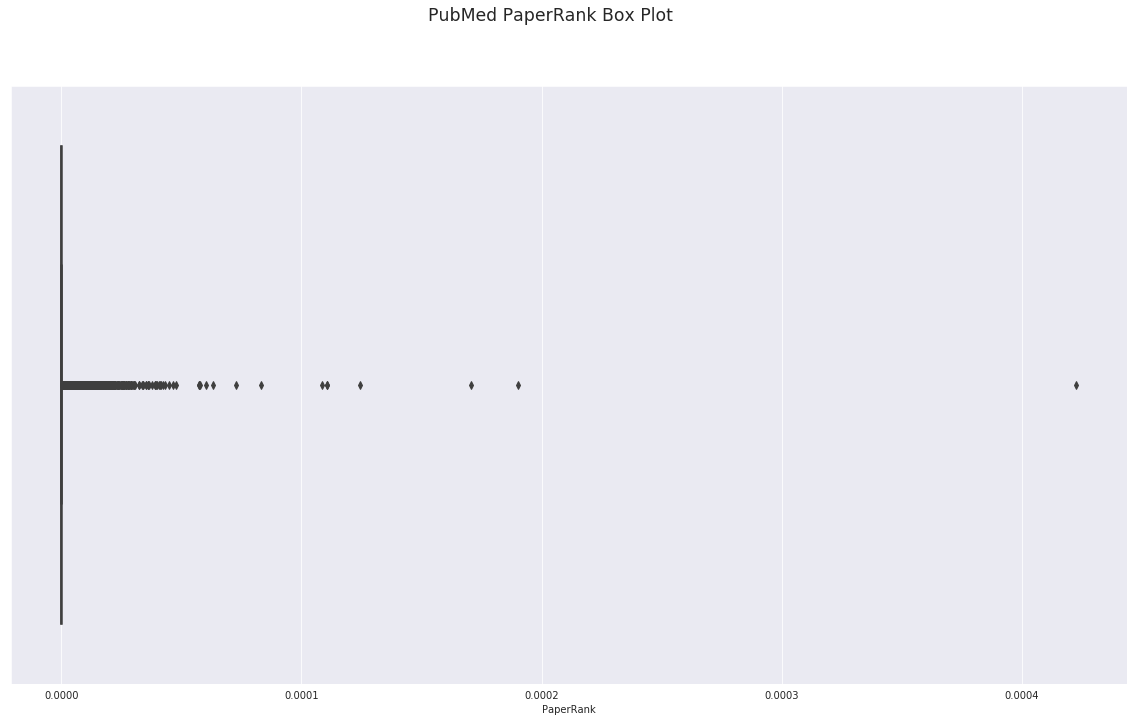

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Box Plot')
ax.set_xlabel('PaperRank')
sns.boxplot(x=pr_rank, ax=ax)

Unfortunately, this plot is not very useful. The figure indicates that the majority of ranks are clustered at the lower end of the spectrum. Qualitatively, this makes sense as the majority of publications are not highly cited; and thus have a low PaperRank.

#### Histogram

To better understand the distribution of the PaperRanks, we will plot a histogram of the data.

Text(0,0.5,'Count')

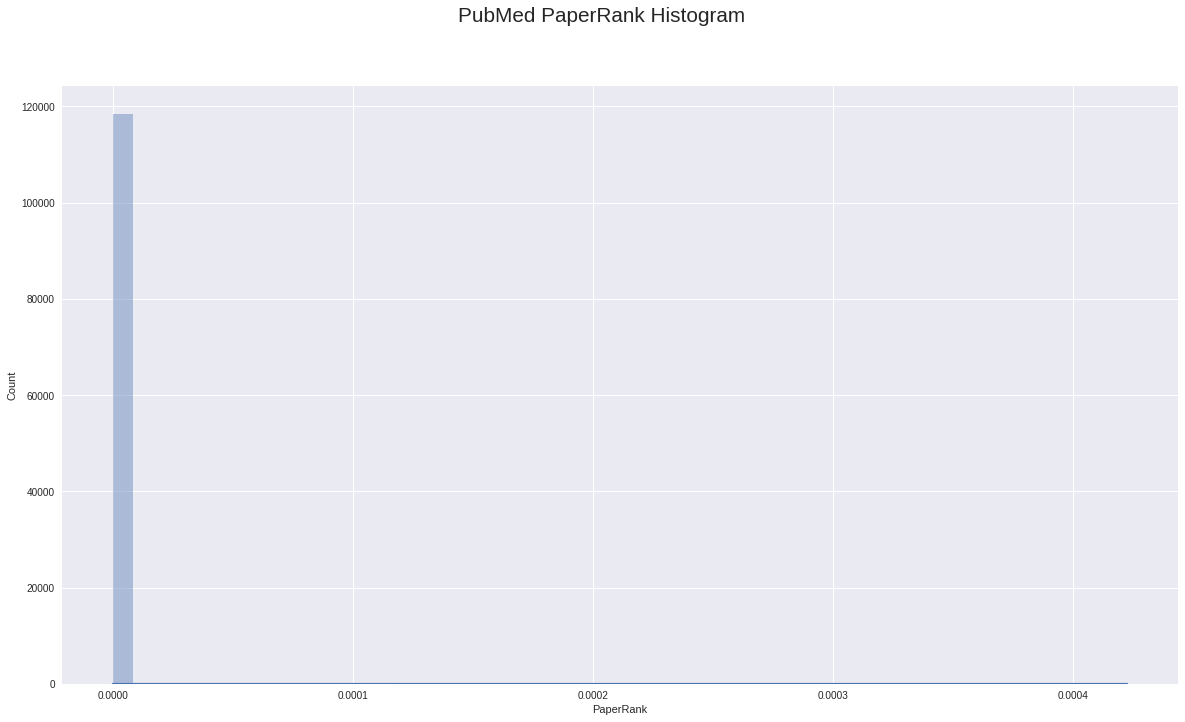

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Histogram')
dp = sns.distplot(pr_rank, kde=True, rug=False, ax=ax)
dp.set_xlabel('PaperRank')
dp.set_ylabel('Count')

#### Scatter Plot

Text(0,0.5,'PaperRank')

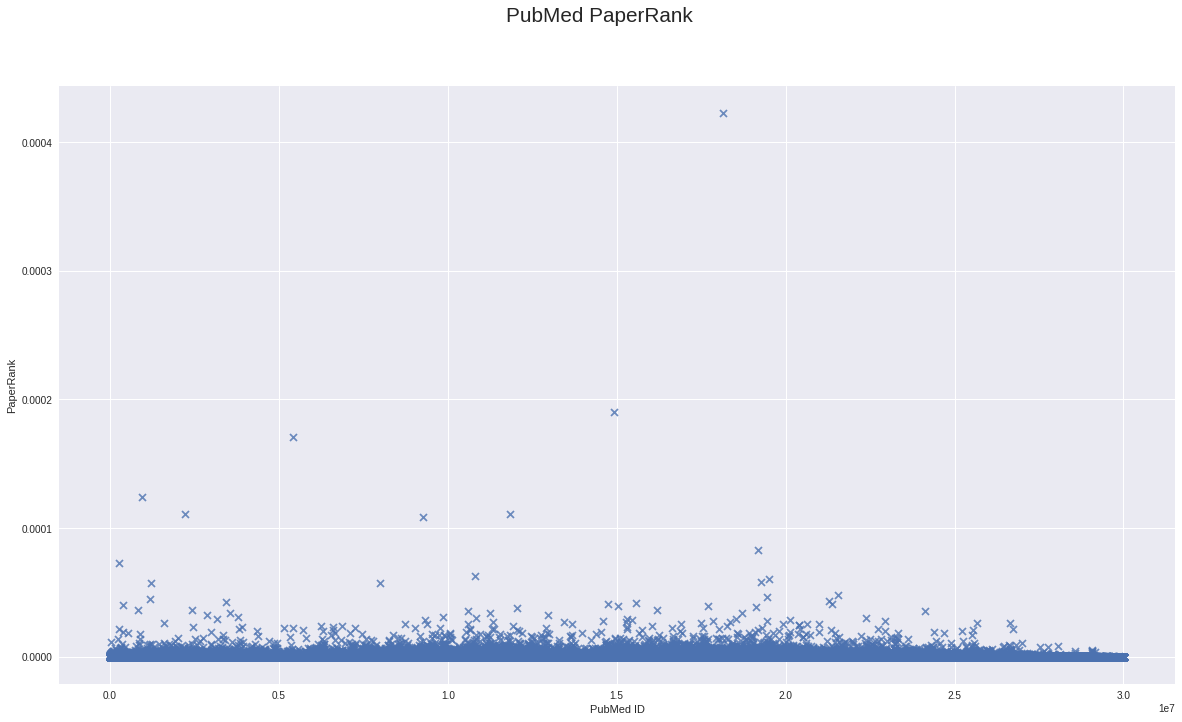

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank')
rp = sns.regplot(x=pr_id, y=pr_rank, fit_reg=False, ax=ax, marker='x')
rp.set_xlabel('PubMed ID')
rp.set_ylabel('PaperRank')

## Frequency Distribution Analysis

In [0]:
# Investigating counts of higher PaperRanks
# This returns a sorted array of unique PaperRanks, and their counts
pr_unique, pr_counts = np.unique(pr_rank, return_counts=True)

# Building frequency table
pr_frequency = pd.DataFrame({'PaperRank': pr_unique,
                             'Count': pr_counts})

# Defining analysis length
a_len = 25

### Max PaperRank Publication Analysis

The following code sorts the counts from highest to lowest. Then, it creates a table of these sorted counts and the corresponding PaperRank (of length `a_len`). Additionally, we also compute a `Z-Score` for each of the PaperRanks, defined as follows:

$$
\text{Let $i^{\text{th}}$ PaperRank } = x_i \\
\text{Let Z-Score of $i^{\text{th}}$ PaperRank} = Z_i \\
\Rightarrow x_i = \mu_{\text{PaperRank}} + Z_i \cdot \sigma_{\text{PaperRank}} \\
\therefore \, Z_i = \frac{x _i- \mu_{\text{PaperRank}}}{\sigma_{\text{PaperRank}}}
$$

In [0]:

# Sorting counts
pr_counts_sorted = np.argsort(pr_counts)[::-1]

# Getting max counts, unique, and Z-Score
pr_counts_max = pr_counts[pr_counts_sorted[0:a_len]]
pr_unique_max = pr_unique[pr_counts_sorted[0:a_len]]
pr_unique_max_log = np.log(pr_unique_max)
pr_z_max = (pr_unique_max - pr_stats['mean']) / pr_stats['sd']

# Building maximum frequencies table
pr_freq_max = pd.DataFrame({'PaperRank': pr_unique_max,
                            'Log PaperRank': pr_unique_max_log,
                            'Count': pr_counts_max,
                            'Z-Score': pr_z_max})

# Displaying table
display(HTML(pr_freq_max.to_html(index=False)))

Count,Log PaperRank,PaperRank,Z-Score
4093546,-17.333065,2.967191e-08,-0.184123
12192,-16.339822,8.011345e-08,0.051770
5919,-16.672964,5.741476e-08,-0.054382
5812,-16.668095,5.769499e-08,-0.053072
5801,-16.662042,5.804528e-08,-0.051433
5782,-16.683153,5.683274e-08,-0.057104
5741,-16.680313,5.699441e-08,-0.056348
5733,-16.689574,5.646898e-08,-0.058805
5719,-16.687715,5.657407e-08,-0.058314
5704,-16.685595,5.669417e-08,-0.057752


As alluded to by the distribution of PaperRanks, the majority of the PaperRanks are clustered toward the mean of the distribution. This is indicated by the low `Z-Score` of each of the PaperRanks.

### Outlier Analysis

As indicated by the very high skew and kurtosis, and as evidenced by the table above, this distribution is very right-skewed. Qualitatively, this means that a majority of publications have a very low PaperRank, and have not been cited extensively. Taking the inverse of this, it means that a few publications are cited very highly. This makes sense in the context of publications; certain works are considered to be extremely influential, while the majority of work is not always built on further.

In this section, we order the data by frequency, and examine the set of outliers on the right end of the distribution. That is, we are examining the articles on PubMed that have the highest PaperRanks. To do this, we simply extract the highest `a_len` PaperRanks, and download the publication metadata for each of the publications.

The following code builds the table of highest PaperRanks, and gets the metadata for each of the publications.

In [0]:
# Creating list of max IDs and ranks
pr_id_max = pr_id[pr_sort_idx[0:a_len]]
pr_rank_max = pr_rank[pr_sort_idx[0:a_len]]

# Updating Z-scores
pr_z_max = (pr_rank_max - pr_stats['mean']) / pr_stats['sd']

pr_freq_head_metadata = pd.DataFrame(columns=['Rank', 'PubMed ID', 'PaperRank',
                                              'Z-Score', 'Title', 'Authors',
                                              'Year', 'Abstract'])

# Building metadata table
for i in range(a_len):
  current_id = str(pr_id_max[i])
  rowdata = [i + 1, current_id, pr_rank_max[i], pr_z_max[i],
             *getPublicationMetadata(current_id)]
  pr_freq_head_metadata.loc[i] = rowdata
  

# Changing Pandas display settings to show full table
pd.set_option('max_colwidth', 1000)
pd.set_option('expand_frame_repr', True)

# Display table
display(HTML(pr_freq_head_metadata.to_html(index=False)))

# Reset Pandas settings
pd.reset_option('max_colwidth')
pd.reset_option('expand_frame_repr')

Rank,PubMed ID,PaperRank,Z-Score,Title,Authors,Year,Abstract
1,18156677,0.000423,1975.811514,A short history of SHELX.,Sheldrick GM,2008,"An account is given of the development of the SHELX system of computer programs from SHELX-76 to the present day. In addition to identifying useful innovations that have come into general use through their implementation in SHELX, a critical analysis is presented of the less-successful features, missed opportunities and desirable improvements for future releases of the software. An attempt is made to understand how a program originally designed for photographic intensity data, punched cards and computers over 10000 times slower than an average modern personal computer has managed to survive for so long. SHELXL is the most widely used program for small-molecule refinement and SHELXS and SHELXD are often employed for structure solution despite the availability of objectively superior programs. SHELXL also finds a niche for the refinement of macromolecules against high-resolution or twinned data; SHELXPRO acts as an interface for macromolecular applications. SHELXC, SHELXD and SHELXE ..."
2,14907713,0.000190,888.671988,Protein measurement with the Folin phenol reagent.,"LOWRY OH, ROSEBROUGH NJ, FARR AL, RANDALL RJ",1951,
3,5432063,0.000171,797.958901,Cleavage of structural proteins during the assembly of the head of bacteriophage T4.,Laemmli UK,1970,
4,942051,0.000124,581.521568,A rapid and sensitive method for the quantitation of microgram quantities of protein utilizing the principle of protein-dye binding.,Bradford MM,1976,
5,2231712,0.000111,516.653379,Basic local alignment search tool.,"Altschul SF, Gish W, Miller W, Myers EW, Lipman DJ",1990,"A new approach to rapid sequence comparison, basic local alignment search tool (BLAST), directly approximates alignments that optimize a measure of local similarity, the maximal segment pair (MSP) score. Recent mathematical results on the stochastic properties of MSP scores allow an analysis of the performance of this method as well as the statistical significance of alignments it generates. The basic algorithm is simple and robust; it can be implemented in a number of ways and applied in a variety of contexts including straightforward DNA and protein sequence database searches, motif searches, gene identification searches, and in the analysis of multiple regions of similarity in long DNA sequences. In addition to its flexibility and tractability to mathematical analysis, BLAST is an order of magnitude faster than existing sequence comparison tools of comparable sensitivity."
6,11846609,0.000111,516.627684,Analysis of relative gene expression data using real-time quantitative PCR and the 2(-Delta Delta C(T)) Method.,"Livak KJ, Schmittgen TD",2001,"The two most commonly used methods to analyze data from real-time, quantitative PCR experiments are absolute quantification and relative quantification. Absolute quantification determines the input copy number, usually by relating the PCR signal to a standard curve. Relative quantification relates the PCR signal of the target transcript in a treatment group to that of another sample such as an untreated control. The 2(-Delta Delta C(T)) method is a convenient way to analyze the relative changes in gene expression from real-time quantitative PCR experiments. The purpose of this report is to present the derivation, assumptions, and applications of the 2(-Delta Delta C(T)) method. In addition, we present the derivation and applications of two variations of the 2(-Delta Delta C(T)) method that may be useful in the analysis of real-time, quantitative PCR data."
7,9254694,0.000108,506.743360,Gapped BLAST and PSI-BLAST: a new generation of protein database search programs.,"Altschul SF, Madden TL, Schäffer AA, Zhang J, Zhang Z, Miller W, Lipman DJ",1997,"The BLAST programs are widely used tools for searching protein and DNA databases for sequence similarities. For protein comparisons, a variety of definitional, al

## Bayesian Gaussian Mixture Model (GMM)

Interpreting the distribution analysis, the histograms of the `Log PaperRank` ([Log PaperRank Histogram](#scrollTo=F7GlUvMs5PVc)) and `InvCDF PaperRank` ([InvCDF PaperRank Histogram](#scrollTo=zp4VNTlIDLHy)) (in the next section; this is just here for clarity) stand out in particular. It suggests a distinct bimodality in the data.

A possible explanation of this bimodality can be developed by considering the nature of the underlying process the PubMed PaperRank is modeling. Academic publications are - in practice - judged by the number of citations they gather. It is also a fair assertion that - by definition - most publications are not highly cited. Rather, it is a few publications that tend to get cited a disproportionate amount of times ([Outlier Analysis](#scrollTo=unTGsWdpYl5f)), compared to the average. It can also be observed that the majority of scientific publications do not go on to be cited, and are thus *dangling* nodes in the PubMed PaperRank graph.

This is the behavior is reflected in the histogram - the majority are not cited (the first mode), and the second-largest group are the papers the are cited an average number of times. The effect of a few ouliers being cited disproportionately more than the rest is seen in the long tail of the distribution.

Following this observation, we defined 3 categories, to capture the gist of the features of the underlying Academic Publication process. Please note that the names are arbitrary, and do not necessarily imply that an article is completely not trusted; they are still articles published in peer-reviewed journals.

1. *Not Trusted* (hereafter **A**)
2. *Trusted* (hereafter **B**)
3. *Highly Trusted* (hereafter **C**)

With the end goal of predicting the probability of each element being in a given category, we model the PaperRank transformations as a Mixed Gaussian Distributions. Specifically, a [Variational Bayesian estimation of a Gaussian Mixture](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), with a priori weights dervied from a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution).

## Log Transformation
This section discusses the log transformation of PaperRank.

### Computation

In [0]:
pr_log = np.log(pr_rank)

### Descriptive Statistics


In [0]:
pr_log_stats = computeDescriptiveStatistics(pr_log)

displayDescriptiveStatistics(stats=pr_log_stats, name='Log PaperRank')

,Log PaperRank
mean,-1.679416e+01
sd,6.344974e-01
var,4.025870e-01
skew,1.553334e+00
kurtosis,3.291845e+00
median,-1.706546e+01
min,-1.733306e+01
max,-7.769177e+00
range,9.563888e+00
N,1.448364e+07


### Distribution Plots

#### Box Plot

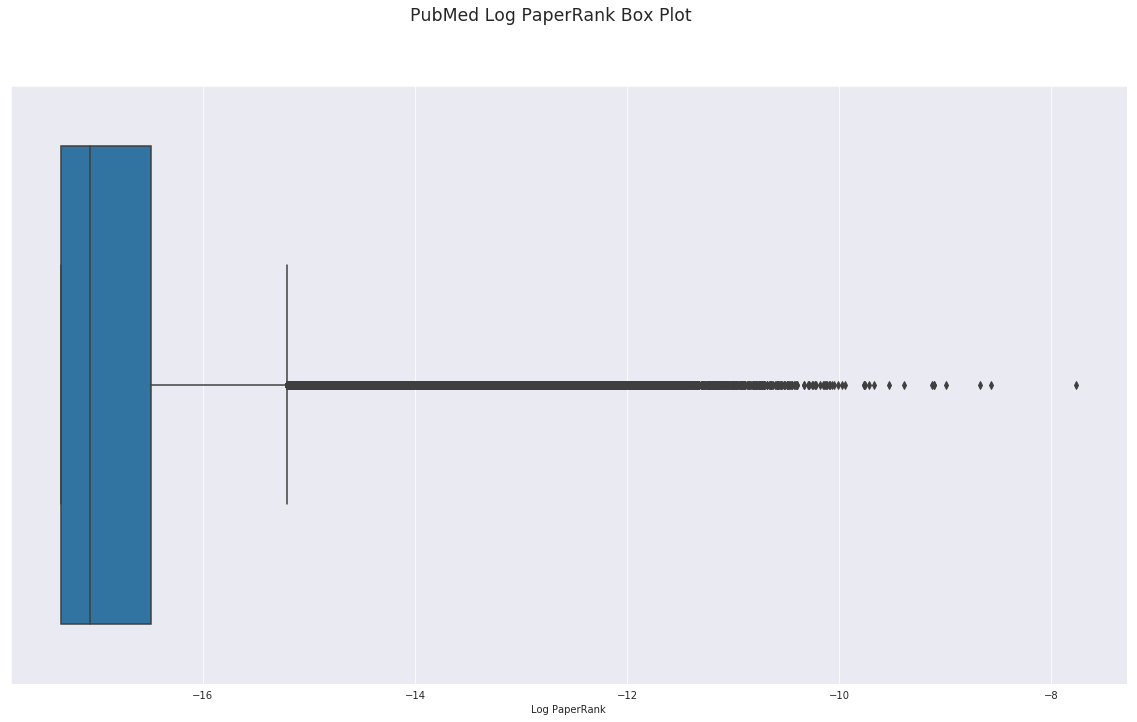

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Log PaperRank Box Plot')
ax.set_xlabel('Log PaperRank')
sns.boxplot(x=pr_log, ax=ax)

#### Histogram

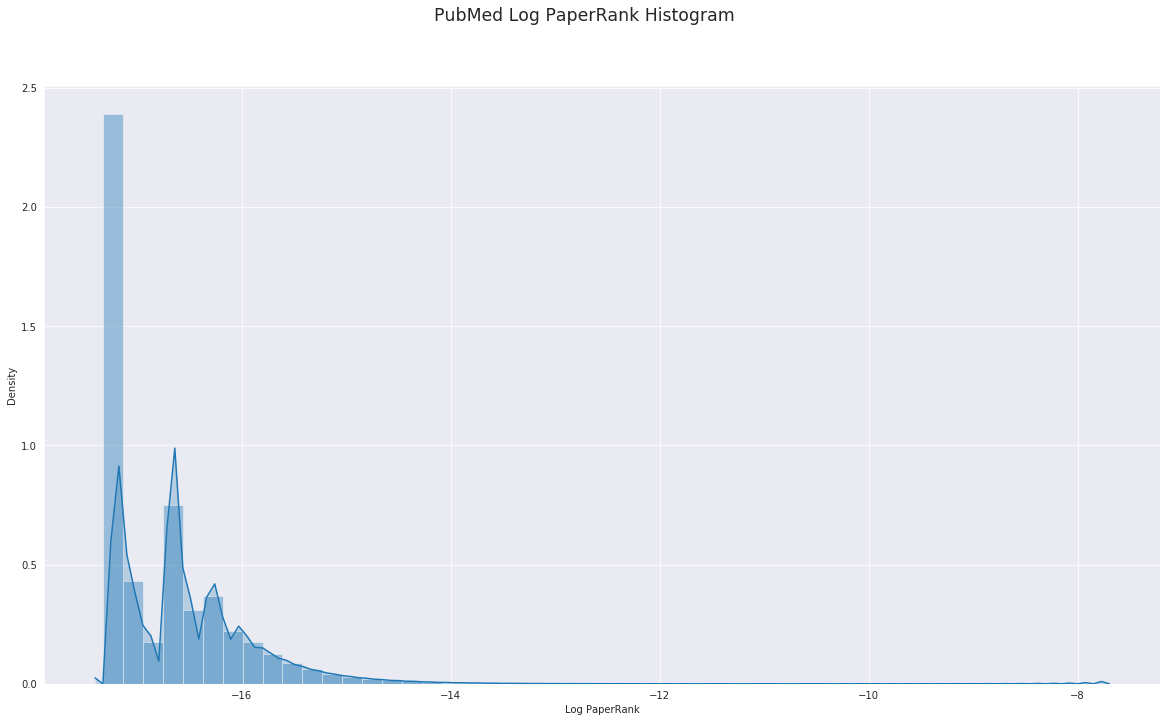

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Log PaperRank Histogram')
ax.set_xlabel('Log PaperRank')
ax.set_ylabel('Density')
sns.distplot(pr_log, kde=True, rug=False, kde_kws={'shade': True}, ax=ax)

#### Scatter Plot

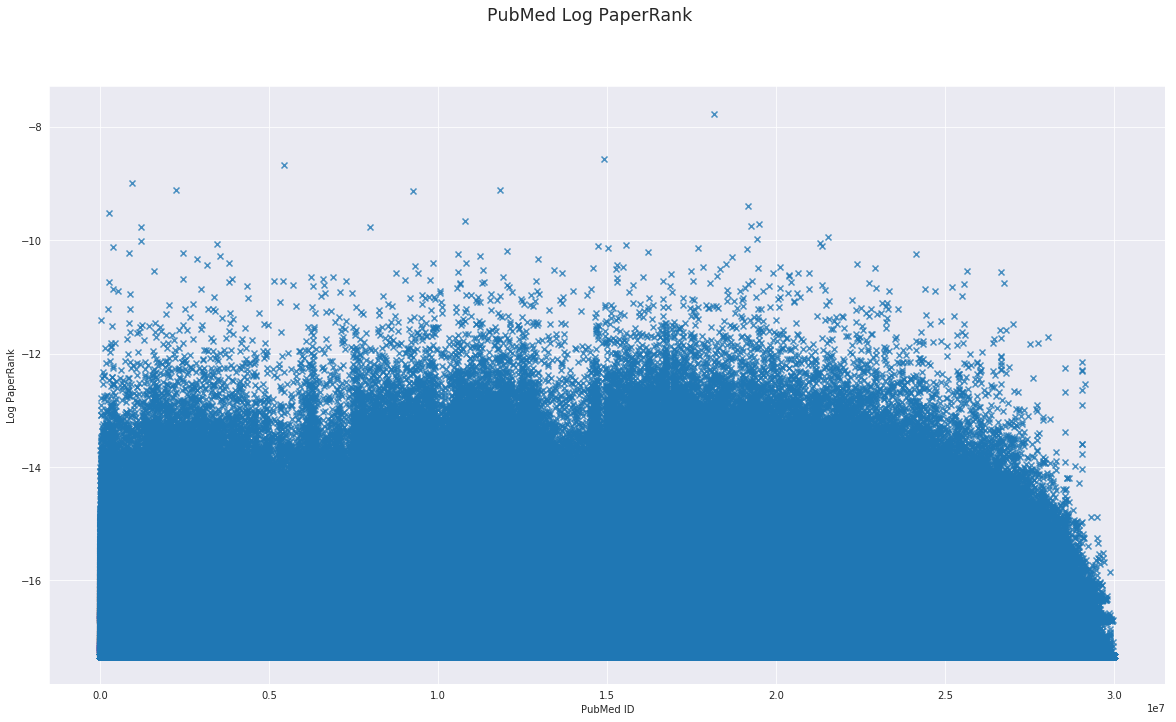

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Log PaperRank')
ax.set_xlabel('PubMed ID')
ax.set_ylabel('Log PaperRank')
sns.regplot(x=pr_id, y=pr_log, fit_reg=False, ax=ax, marker='x')

This plot is significantly more insightful. While it does still indicate that a bulk of the PaperRanks are indeed clustered toward the bottom of the distribution, it also captures the noticable decline in PaperRanks towards the end of the sequence of PubMed IDs.

As identified during the scraping process, the PubMed IDs are a **weak** sorting heuristic, ordering the data by time. It is to be expected that newer publications would have a lower PaperRank on average, as they have not been cited by publications yet. This expectation is reflected in the scatterplot.

### Heuristic Convergence Test

To verify the heuristic, we conducted a series of convergence tests for a Variational Bayesian Mixed Gaussian Distribution by computing a mixture model with 3 components, with a priori weights derived from a Dirichlet distribution. 

To do this, we used [`sklearn.mixture.BayesianGaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture).

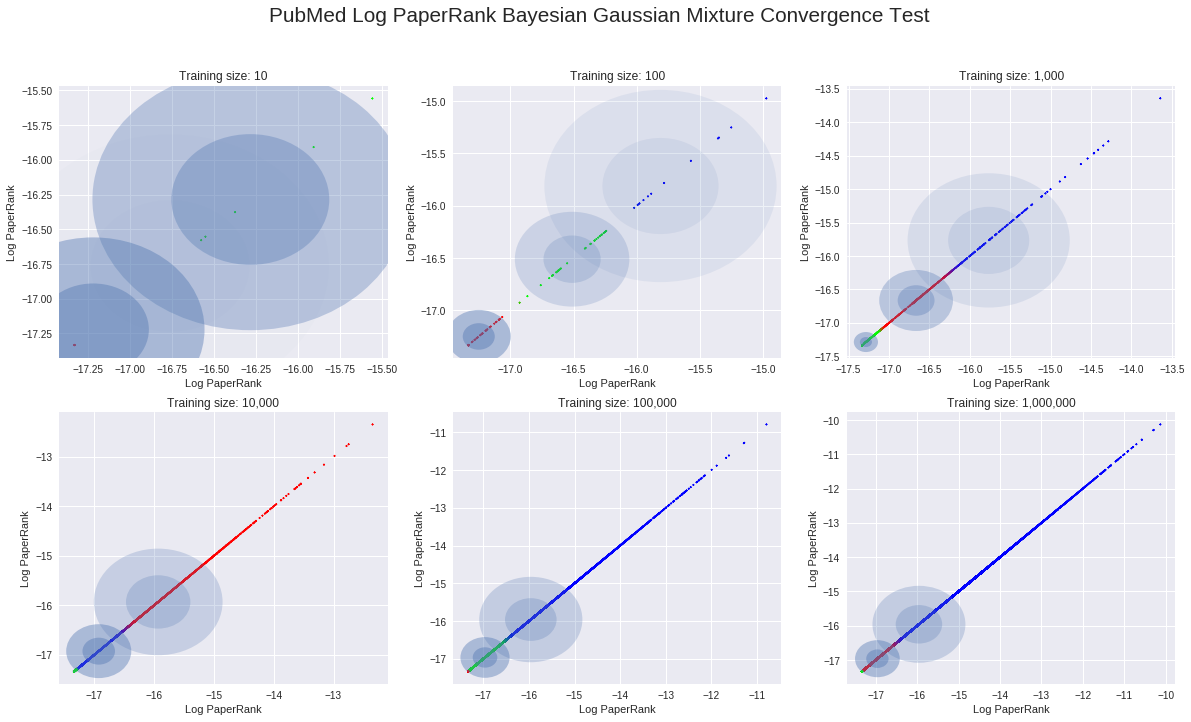

In [0]:
# Create split plot to show all training sizes
# fig, axs = plt.subplots(2, 3, figsize=dims_large, sharex='all', sharey='all')
fig, axs = plt.subplots(2, 3, figsize=dims_large)

# Set title
fig.suptitle('PubMed Log PaperRank Bayesian Gaussian Mixture Convergence Test',
             fontsize='xx-large')

# Iterate in powers of 10 from 10 to 1,000,000
for i in range(1, 7):
  # Set idx (for subplot indexing)
  idx = i - 1
  nrow = int(idx / 3)
  ncol = idx % 3

  # Set axes
  ax = axs[nrow][ncol]
  
  # Set axis labels
  ax.set_xlabel('Log PaperRank')
  ax.set_ylabel('Log PaperRank')
  
  # Set training size
  train_size = 10**i
  
  # Sample training set from full distribution
  pr_train = np.random.choice(pr_log, train_size)
  
  # Instantiate model
  model = mixture.BayesianGaussianMixture(n_components=3,
                                          covariance_type='diag')

  # Create data object for model
  X = np.array([pr_train, pr_train]).T
  
  # Predict entire training dataset
  preds = model.fit(X).predict_proba(X)

  # Plot graph
  drawMixtureModel(model=model, preds=preds, X=X, ax=ax)

### GMM Model Training

**NOTE: THIS TAKES A LONG TIME; DO NOT RUN UNLESS NECESSARY**

In [0]:
# Training the model

# Input Data
X = np.array([pr_log, pr_log]).T

# Instantiating Model
pr_log_model = mixture.BayesianGaussianMixture(n_components=3,
                                               covariance_type='diag')

# Training model on entire dataset
pr_log_model_fit = pr_log_model.fit(X)

# Predict over entire dataset, sort predictions
pr_log_preds_unsorted = pr_log_model_fit.predict_proba(X)
pr_log_preds = np.copy(cleanPredictions(pr_log_preds_unsorted))

#### Model Backup

This section contains code to save the model and related variables to the `PaperRank-Analysis/models` folder on Google Drive. This code can only be run by Collaborators.

*Note: If this throws an Exception, you may have to sign in again [here](#scrollTo=njsus7GqJic6).*

In [0]:
# Variables to save
save_items = {
    'pr_log_model': pr_log_model,
    'pr_log_model_fit': pr_log_model_fit,
    'pr_log_preds': pr_log_preds,
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying delete of 3 files in `models/` folder
Deleted 0 files in `models/` folder
Starting variable upload
Uploaded variable to file pr_log_model with ID 1wo8gXD0Ql_5TiDrv7zgS0PuoCZ57kc9S
Uploaded variable to file pr_log_model_fit with ID 1xDUvDteDchJAt_bCWEMwmV0ETeZ9B9D9
Uploaded variable to file pr_log_preds with ID 1t3IZz1UgHOn1Yz7BjaFG064RgqvYAdAe
Finished uploading 3 variables


### Model Parameters

In [0]:
# Model parameters
pr_log_model_stat = getModelParameters(pr_log_model)

# Display
displayModelParameters(pr_log_model_stat)

,mean,var
A (Not Trusted),-17.333065,0.000001
B (Trusted),-16.963587,0.072773
C (Highly Trusted),-15.960862,0.314098


### Model Visualization

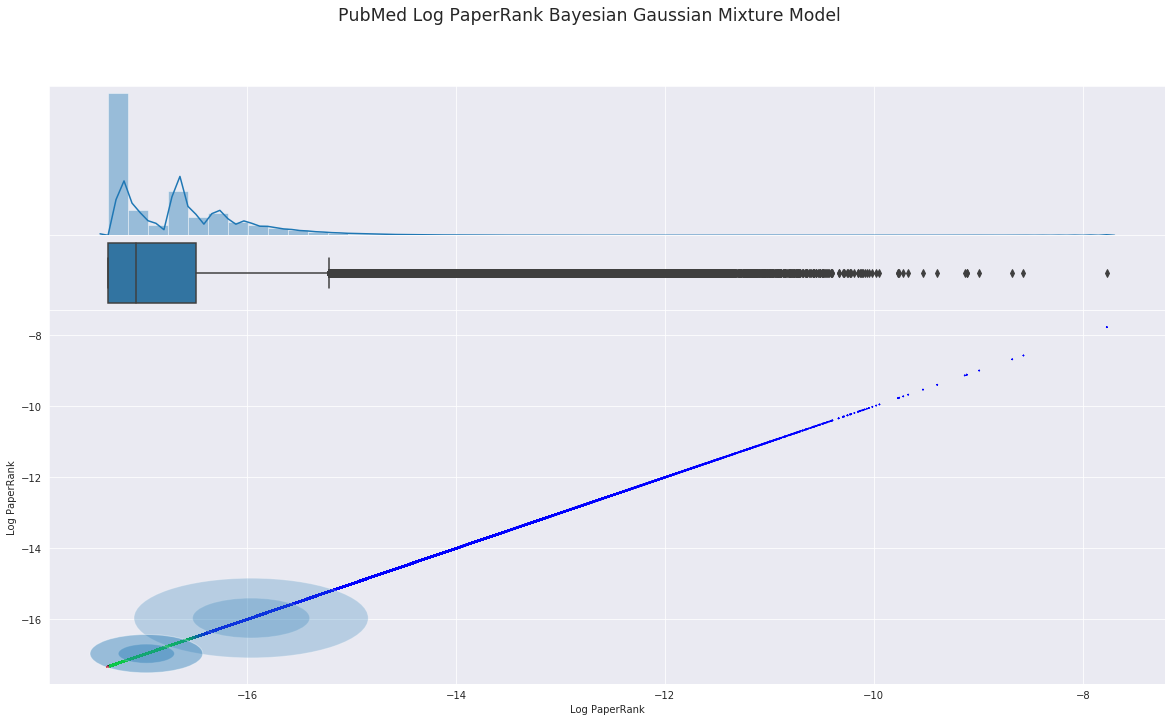

In [0]:
# Create split plot to show histogram and boxplot with model graph
fig, axs = plt.subplots(3, 1, figsize=dims_large, sharex=True,
                        gridspec_kw={'height_ratios':[2,1,5], 'hspace': 0})

# Set title
fig.suptitle('PubMed Log PaperRank Bayesian Gaussian Mixture Model',
             fontsize='xx-large')


# Top plot
#---------

# Set axes
ax = axs[0]
# Plot Histogram
sns.distplot(pr_log, kde=True, rug=False, ax=ax)
# Clear y-axis ticks
ax.set_yticks([])

# Middle plot
#---------

# Set axes
ax = axs[1]
# Plot Box plot
sns.boxplot(pr_log, ax=ax)

# Bottom plot
#------------

# Set axes
ax = axs[2]
ax.set_xlabel('Log PaperRank')
ax.set_ylabel('Log PaperRank')
# Input Data
X = np.array([pr_log, pr_log]).T
# Plot graph
drawMixtureModel(model=pr_log_model, preds=pr_log_preds, X=X, ax=ax, set_title=False)

## Inverse CDF Transformation

As an alternative to the log transformation used in the previous section, here we tried using the inverse CDF.

### Computation

In [0]:
pr_invcdf = norm.ppf(pr_rank)

### Descriptive Statistics

In [0]:
pr_invcdf_stats = computeDescriptiveStatistics(pr_invcdf)

displayDescriptiveStatistics(stats=pr_invcdf_stats, name='InvCDF PaperRank')

,InvCDF PaperRank
mean,-5.322405e+00
sd,1.173718e-01
var,1.377613e-02
skew,1.653183e+00
kurtosis,4.003054e+00
median,-5.372732e+00
min,-5.420767e+00
max,-3.337577e+00
range,2.083190e+00
N,1.448364e+07


### Distribution Plots

#### Box Plot

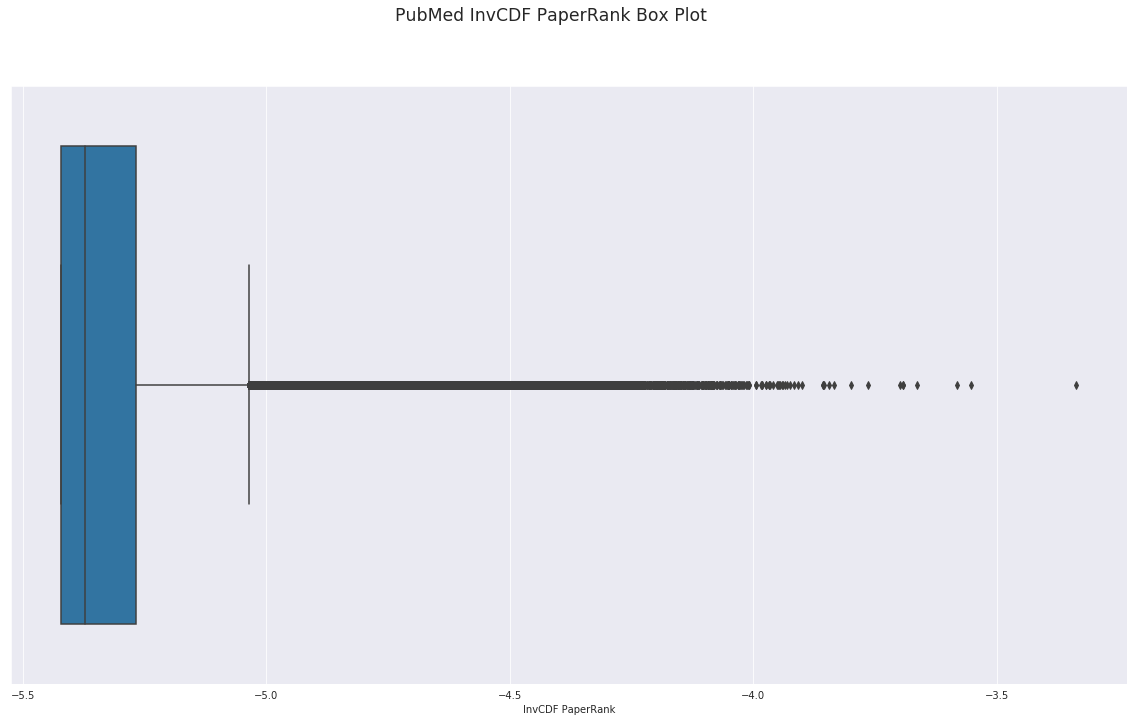

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank Box Plot')
ax.set_xlabel('InvCDF PaperRank')
sns.boxplot(x=pr_invcdf, ax=ax)

#### Histogram

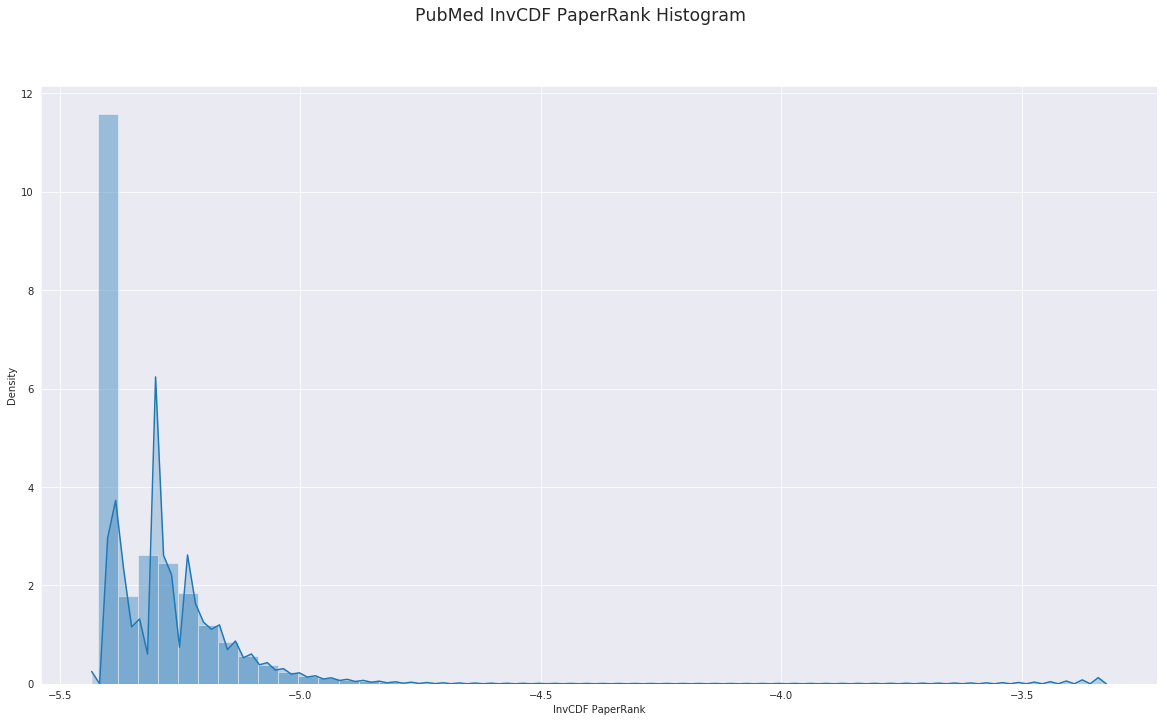

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank Histogram')
ax.set_xlabel('InvCDF PaperRank')
ax.set_ylabel('Density')
sns.distplot(pr_invcdf, kde=True, rug=False, kde_kws={'shade': True}, ax=ax)

#### Scatter Plot

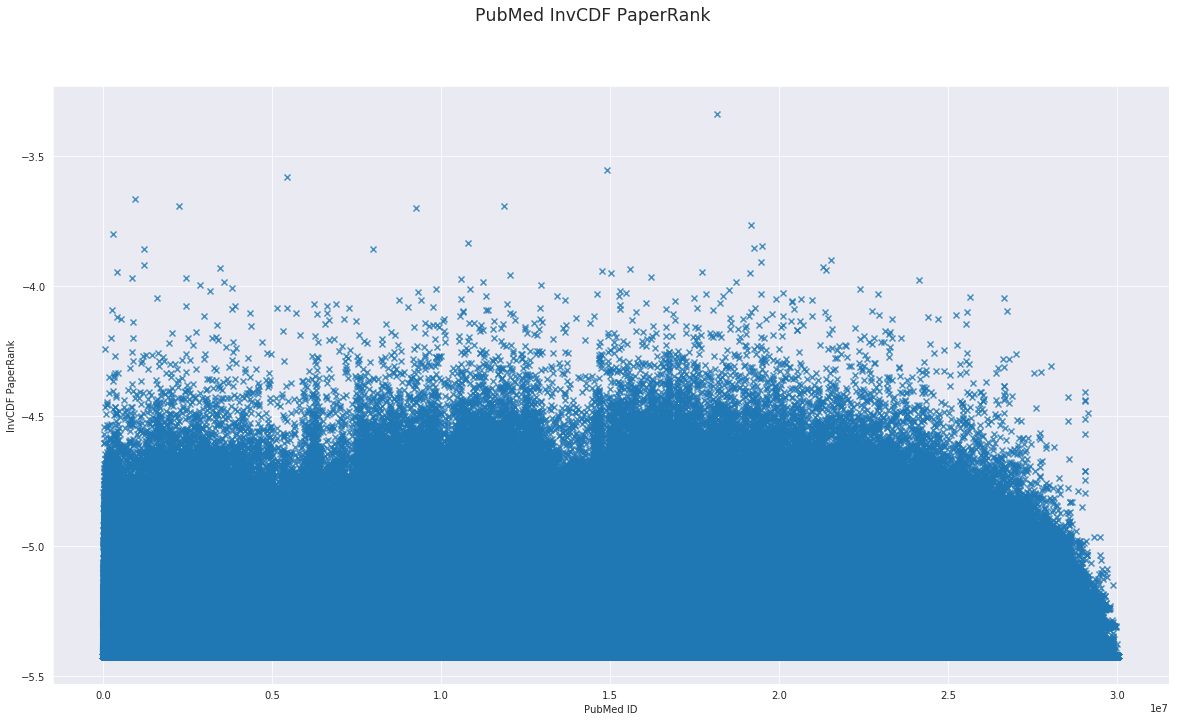

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank')
ax.set_xlabel('PubMed ID')
ax.set_ylabel('InvCDF PaperRank')
sns.regplot(x=pr_id, y=pr_invcdf, fit_reg=False, ax=ax, marker='x')

### Heuristic Convergence Test

To verify the heuristic, we conducted a series of convergence tests for a Variational Bayesian Mixed Gaussian Distribution by computing a mixture model with 3 components, with a priori weights derived from a Dirichlet distribution. 

To do this, we used [`sklearn.mixture.BayesianGaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture).

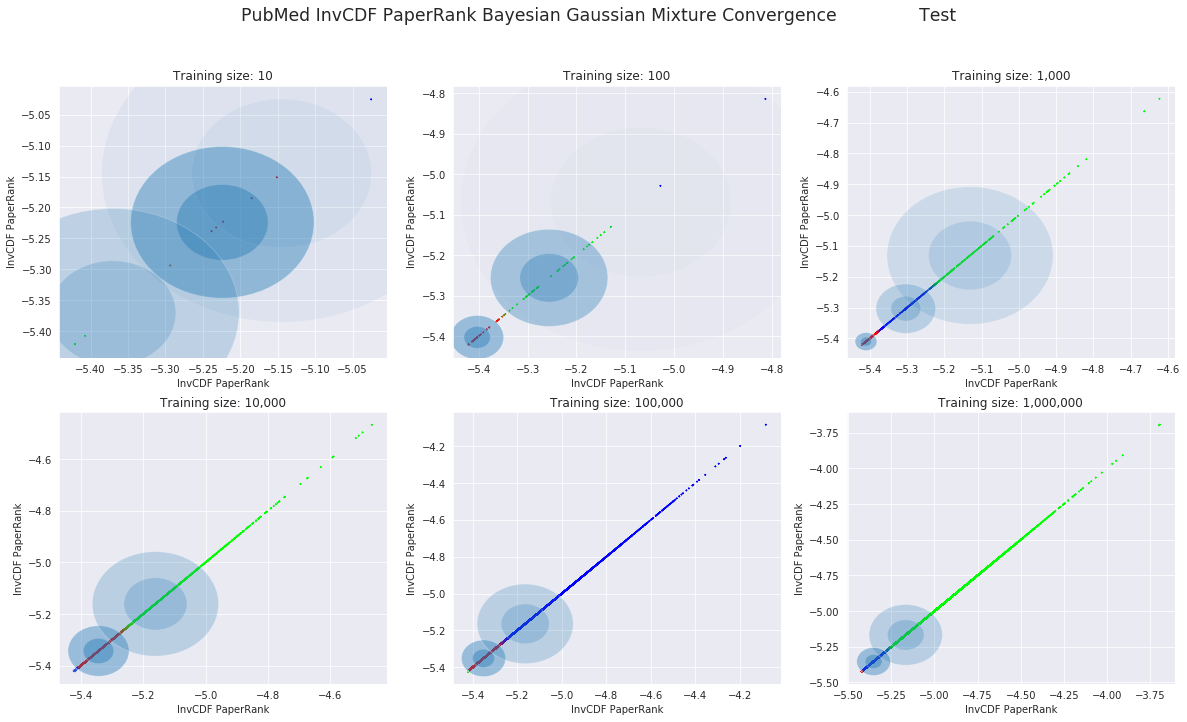

In [0]:
# Create split plot to show all training sizes
# fig, axs = plt.subplots(2, 3, figsize=dims_large, sharex='all', sharey='all')
fig, axs = plt.subplots(2, 3, figsize=dims_large)

# Set title
fig.suptitle('PubMed InvCDF PaperRank Bayesian Gaussian Mixture Convergence Test',
             fontsize='xx-large')

# Iterate in powers of 10 from 10 to 1,000,000
for i in range(1, 7):
  # Set idx (for subplot indexing)
  idx = i - 1
  nrow = int(idx / 3)
  ncol = idx % 3

  # Set axes
  ax = axs[nrow][ncol]
  
  # Set axis labels
  ax.set_xlabel('InvCDF PaperRank')
  ax.set_ylabel('InvCDF PaperRank')
  
  # Set training size
  train_size = 10**i
  
  # Sample training set from full distribution
  pr_train = np.random.choice(pr_invcdf, train_size)
  
  # Instantiate model
  model = mixture.BayesianGaussianMixture(n_components=3,
                                          covariance_type='diag')

  # Create data object for model
  X = np.array([pr_train, pr_train]).T
  
  # Predict entire training dataset
  preds = model.fit(X).predict_proba(X)

  # Plot graph
  drawMixtureModel(model=model, preds=preds, X=X, ax=ax)

### GMM Model Training

**NOTE: THIS TAKES A LONG TIME; DO NOT RUN UNLESS NECESSARY**

In [0]:
# Training the model

# Input Data
X = np.array([pr_invcdf, pr_invcdf]).T

# Instantiating Model
pr_invcdf_model = mixture.BayesianGaussianMixture(n_components=3,
                                                  covariance_type='diag')

# Training model on entire dataset
pr_invcdf_model_fit = pr_invcdf_model.fit(X)

# Predict over entire dataset, sort predictions
pr_invcdf_preds_unsorted = pr_invcdf_model_fit.predict_proba(X)
pr_invcdf_preds = np.copy(cleanPredictions(pr_invcdf_preds_unsorted))

#### Model Backup

This section contains code to save the model and related variables to the `PaperRank-Analysis/models` folder on Google Drive. This code can only be run by Collaborators.

*Note: If this throws an Exception, you may have to sign in again [here](#scrollTo=njsus7GqJic6).*

In [0]:
# Variables to save
save_items = {
    'pr_invcdf_model': pr_invcdf_model,
    'pr_invcdf_model_fit': pr_invcdf_model_fit,
    'pr_invcdf_preds': pr_invcdf_preds,
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying delete of 3 files in `models/` folder
Deleted 0 files in `models/` folder
Starting variable upload
Uploaded variable to file pr_invcdf_model with ID 1aE0leGpNEKTyZhgaxrnXmYZRFNmFfnyB
Uploaded variable to file pr_invcdf_model_fit with ID 1vN7WTIzAR_orV4BkAvImoVe7PzsWizfN
Uploaded variable to file pr_invcdf_preds with ID 1nUG6E6XiK_6a5HXhB7QD-TCAiEnl4Xid
Finished uploading 3 variables


### Model Parameters

In [0]:
# Model characteristics
pr_invcdf_model_stat = getModelParameters(pr_invcdf_model)

# Display
displayModelParameters(pr_invcdf_model_stat)

,mean,var
A (Not Trusted),-5.420758,0.000001
B (Trusted),-5.352913,0.002438
C (Highly Trusted),-5.166585,0.011371


### Model Visualization

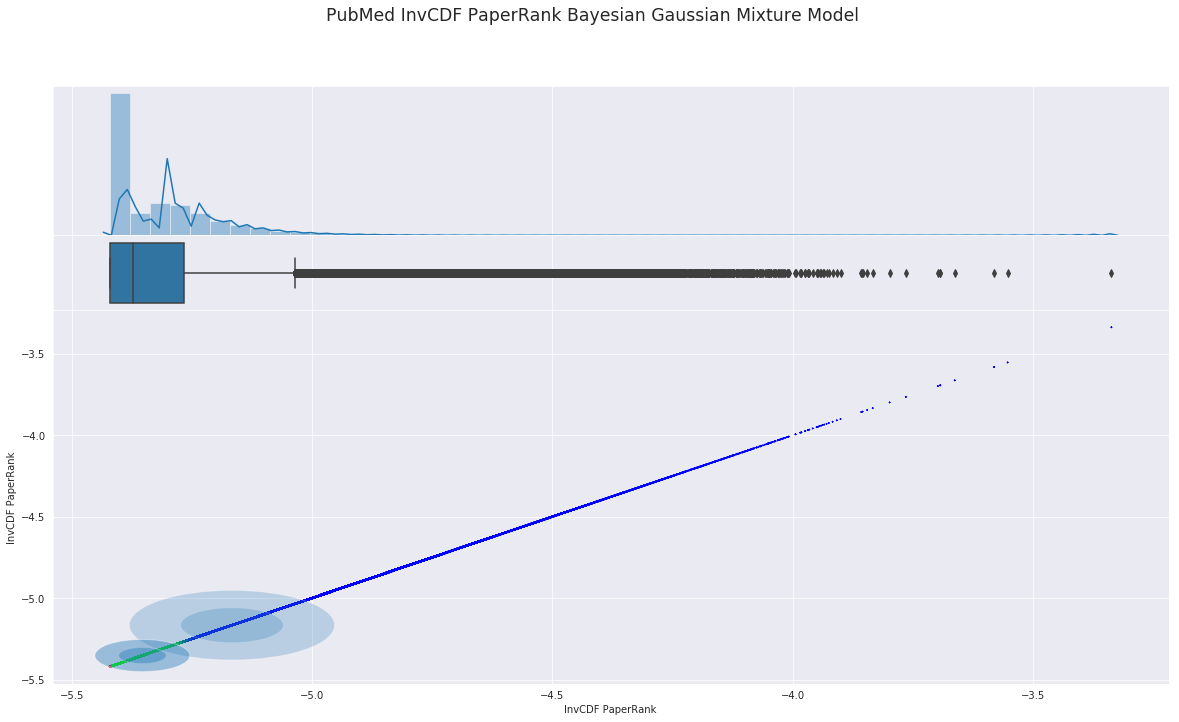

In [0]:
# Create split plot to show histogram and boxplot with model graph
fig, axs = plt.subplots(3, 1, figsize=dims_large, sharex=True,
                        gridspec_kw={'height_ratios':[2,1,5], 'hspace': 0})

# Set title
fig.suptitle('PubMed InvCDF PaperRank Bayesian Gaussian Mixture Model',
             fontsize='xx-large')


# Top plot
#---------

# Set axes
ax = axs[0]
# Plot Histogram
sns.distplot(pr_invcdf, kde=True, rug=False, ax=ax)
# Clear y-axis ticks
ax.set_yticks([])

# Middle plot
#---------

# Set axes
ax = axs[1]
# Plot Box plot
sns.boxplot(pr_invcdf, ax=ax)

# Bottom plot
#------------

# Set axes
ax = axs[2]
ax.set_xlabel('InvCDF PaperRank')
ax.set_ylabel('InvCDF PaperRank')
# Input Data
X = np.array([pr_invcdf, pr_invcdf]).T
# Plot graph
drawMixtureModel(model=pr_invcdf_model, preds=pr_invcdf_preds, X=X, ax=ax,
                 set_title=False)

## InvCDF GMM Trust Score

In this section, we define and derive the notion of a *trust score*. Here, we use the word *trust* not in the absolute sense, but rather in the sense of community trust.

### Model Clusters

To compute the trust scores, we will utilize the [Bayesian Gaussian Mixture Mode](#scrollTo=qw2yKYh2EDOA) fit to the [Inverse CDF transformed PaperRank](#scrollTo=CKu6xfDx3TFB).

In [0]:
# Model characteristics
stats = getModelParameters(pr_invcdf_model)

# Display
displayModelParameters(stats)

,mean,var
A (Not Trusted),-5.420758,0.000001
B (Trusted),-5.352913,0.002438
C (Highly Trusted),-5.166585,0.011371


### Baseline Trust

To correctly scale our *trust* score, we must define a level of baseline trust, $P(T)$. This represents the baseline level of trust assumed to be inherent in each of the publications, as a result of them being published in peer reviewed journals.

Being a probability distribution, $P(T)$ ranges from 0 to 1. 0 represents no trust, and 1 represents complete trust.

we set the `baseline_trust` to 0.5. That is, we assume that the baseline level of trust by being published in a peer reviewed journal is neither trusted nor untrusted.

$$
P(T) = 0.5
$$

In [0]:
baseline_trust = 0.5

### Membership Probabilities

We utilize the predicted probabilities from the [Inverse CDF PaperRank Bayesian Gaussian Mixture Model](#scrollTo=CgjDurHaFlMv). Here, the model predicts the probability of membership in each of the clusters, given it is not in any of the other clusters. That is, it gives us:

<br>

$$
P(A_i) = P(A \cap (B \cup C)^\complement) \\
P(B_i) = P(B \cap (A \cup C)^\complement) \\
P(C_i) = P(C \cap (A \cup B)^\complement)
$$

The following function extracts the membership probabilities for a given cluster, and casts these values to [decimal.Decimal](https://docs.python.org/3/library/decimal.html) for better precision. It also backs up each of the membership probabilities directly to Google Drive for easier reuse (this is necessary due to VM memory constraints).

In [0]:
def extractMembershipProbability(pr_invcdf_preds: np.ndarray, i: int,
                                 name: str) -> np.array:
  """Function to extract the membership probability, given the list of
  model predictions.
  
  Arguments:
    pr_invcdf_preds {np.ndarray} -- Array of predictions from the model.
    i {int} -- Column index of the target predictions.
    name {str} -- Name of the saved file in Google Drive.
  
  Returns:
    {np.array} -- Array of extracted membership probabilities.
  """
  
  # Getting membership probability and casting to decimal
  print('Computing probabilities for {}'.format(name))
  prob = np.array([Decimal(i) for i in pr_invcdf_preds[:,i]], dtype=Decimal)
  
  # Saving to Drive
  print('Saving {} to Drive'.format(name))
  saveVariables(variables={name: prob})
  print('Saved {} to Drive'.format(name))
  
  # Return extracted probabilities
  return prob

The code below extracts the probabilities for each of the 3 clusters. It is done individually to not cause a memory overflow in the VM.

In [0]:
# Extracting membership probabilities
p_a = extractMembershipProbability(pr_invcdf_preds=pr_invcdf_preds,
                                   i=0, name='p_a')
p_b = extractMembershipProbability(pr_invcdf_preds=pr_invcdf_preds,
                                   i=1, name='p_b')
p_c = extractMembershipProbability(pr_invcdf_preds=pr_invcdf_preds,
                                   i=2, name='p_c')

Computing probabilities for p_a
Saving p_a to Drive
Trying to delete 1 files in the `models/` folder
Deleting file p_a with ID 1T6IL7flx1K0n-iNsRld05umg1-F7zkaN
Deleted 1 files in `models/` folder
Starting variable upload
Uploaded variable to file p_a with ID 1dtM2fDY5_Blp8PWwN0vPy-WgDTFRqEKM
Finished uploading 1 variables
Saved p_a to Drive
Computing probabilities for p_b
Saving p_b to Drive
Trying to delete 1 files in the `models/` folder
Deleted 0 files in `models/` folder
Starting variable upload
Uploaded variable to file p_b with ID 1qmPvsxLedcoNU13SclRHAm9i0mQuOJhD
Finished uploading 1 variables
Saved p_b to Drive
Computing probabilities for p_c
Saving p_c to Drive
Trying to delete 1 files in the `models/` folder
Deleted 0 files in `models/` folder
Starting variable upload
Uploaded variable to file p_c with ID 19fNqy02Opvt8u4rz2AE9xV2es2Wsva8I
Finished uploading 1 variables
Saved p_c to Drive


### Formula Derivation

We define the probability of trust to be the probability that a given pubication, $D$ is trusted.

<br>

$$
\text{Let probability of trust for a given publication} = P(T|D)
$$

<br>

Recall Bayes' theorem:

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

Applying this to the probability of trust, $P(T|D)$, we get:

$$
P(T|D) = \frac{P(D|T)P(T)}{P(D)}
$$

We can expand the probability of the $P(D)$ into its conditional components:

$$
P(D) = P(D|T)P(T) + P(D|T^\complement)P(T^\complement) \\
\text{But,} \; P(T^\complement) = 1 - P(T) \\
\Rightarrow P(D) = P(D|T)P(T) + P(D|T^\complement)(1-P(T))
$$

Substituting this into the Bayes' theorem expansion of $P(T|D)$:

<br>

$$
\therefore \; P(T|D) = \frac{P(D|T)P(T)}{P(D|T)P(T) + P(D|T^\complement)(1-P(T))}
$$

<br>

To compute the final trust metric for the $i^\text{th}$ page $\tau_i$, we must scale $P(T|D)$ by the baseline probability, $P(T)$

<br>

$$
\therefore \, \tau_i = P(T) + P(T | D)(1 - P(T))
$$

In [0]:
def computeTrust(pr_t: np.array, pr_nt: np.array,
                 baseline_trust: np.float) -> np.array:
  """Function to compute the trust value for a given set of
  membership probabilities of trusted and untrusted publications.
  Note: Numerator and Denominator must be computed separately to avoid
  crashing due to a lack of memory.
  
  Arguments:
    pr_t {np.array} -- List of probabilities that a publication is trusted.
    pr_nt {np.array} -- List of probabilities that a publication is not trusted.
  
  Returns:
    {np.array} -- List of trust values.
  """

  # Casting to Decimal
  baseline_trust = Decimal(baseline_trust)

  # Create empty array of same type and shape as pr_t
  trust = np.empty_like(pr_t)
  
  # Flags
  count = 0
  decile = 1
  n = len(pr_t)
  
  # Computing trust for each element (loop due to VM memory issues)
  for i in range(0, len(pr_t)):
    scaled_pr_t = pr_t[i] * baseline_trust
    scaled_pr_nt = pr_nt[i] * (1 - baseline_trust)
    unscaled_trust = scaled_pr_t / (scaled_pr_t + scaled_pr_nt)
    trust[i] = baseline_trust + (unscaled_trust * (1 - baseline_trust))
  
    # Logging every 10%
    if int((count * 10) / n) == 1:
      print('Trust computation {}% complete'.format(decile * 10))
      decile += 1
      count = 0
    
    count += 1
  
  return trust

### Trust Categories

Utilizing the probabilities predicted in the Inverse CDF transformed PaperRank, we define:

$$
\text{Let} \; P(D|T) = P(C \cap (A \cup B)^\complement)
$$

This indicates that the probability of a given publication being trusted, $P(D|T)$ is equal to the probability it is a member of the third cluster (**C**, *Highly Trusted*).

In [0]:
pr_t = p_c

Similarly, we define the probability of a given publication being not trusted, $P(D|T^\complement)$ to be the probability a publication is a member of the first (**A**, *Not Trusted*) or second cluster (**B**,  *Trusted*).

$$
\text{Let} \; P(D|T^\complement) = P((A \cup B) \cap C^\complement) \\
\text{Where} \;P((A \cup B) \cap C^\complement) = P(A \cap (B \cup C)^\complement) + P(B \cap (A \cup C)^\complement)
$$

In [0]:
pr_nt = p_a + p_b

### Trust Score Computation

In this section, we compute the trust score for each of the publications.

In [0]:
# Computing trust scores
pr_trust = computeTrust(pr_t=pr_t, pr_nt=pr_nt, baseline_trust=baseline_trust)

# Casting to np.float for graphing
pr_trust_float = pr_trust.astype(np.float)

Trust computation 10% complete
Trust computation 20% complete
Trust computation 30% complete
Trust computation 40% complete
Trust computation 50% complete
Trust computation 60% complete
Trust computation 70% complete
Trust computation 80% complete
Trust computation 90% complete


#### Trust Score Backup

In this section, we back up the trust scores and relevant probabilities.

In [0]:
# Variables to save
save_items = {
    'pr_trust': pr_trust,
#     'pr_t': pr_t,
#     'pr_nt': pr_nt
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying to delete 1 files in the `models/` folder
Deleting file pr_trust with ID 1D9o0-LhDcFaerA726d9lu9WVwrgV09jt
Deleted 1 files in `models/` folder
Starting variable upload
Uploading file with variable pr_trust of size 777948647
Removing temporary file of 777948647 bytes
Uploaded variable to file pr_trust with ID 1jxylaVRCaJ0FVrNbb9SFgdOz8LrK4Oxl
Finished uploading 1 variables


### Trust Statistics

This section contains sample statistics for the trust scores.

In [0]:
pr_trust_stats = computeDescriptiveStatistics(pr_trust_float)

displayDescriptiveStatistics(stats=pr_trust_stats,
                             name='PubMed PaperRank Trust')

,PubMed PaperRank Trust
mean,6.335087e-01
sd,2.048965e-01
var,4.198257e-02
skew,1.107230e+00
kurtosis,-6.587289e-01
median,5.017762e-01
min,5.000001e-01
max,1.000000e+00
range,4.999999e-01
N,1.448364e+07


### Trust Distribution Plots

This section contains plots of the PaperRank trust score distribution.

#### Histogram

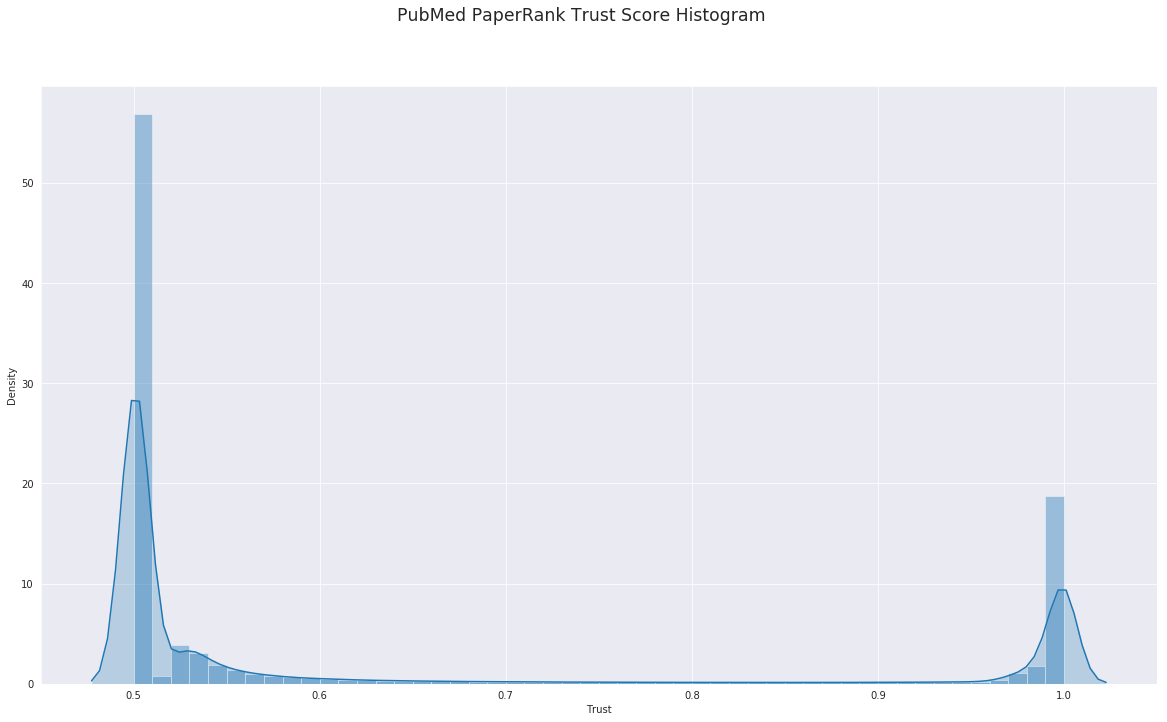

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Trust Score Histogram')
ax.set_xlabel('Trust')
ax.set_ylabel('Density')
sns.distplot(pr_trust_float, kde=True, rug=False, kde_kws={'shade': True}, ax=ax)

#### Scatterplot

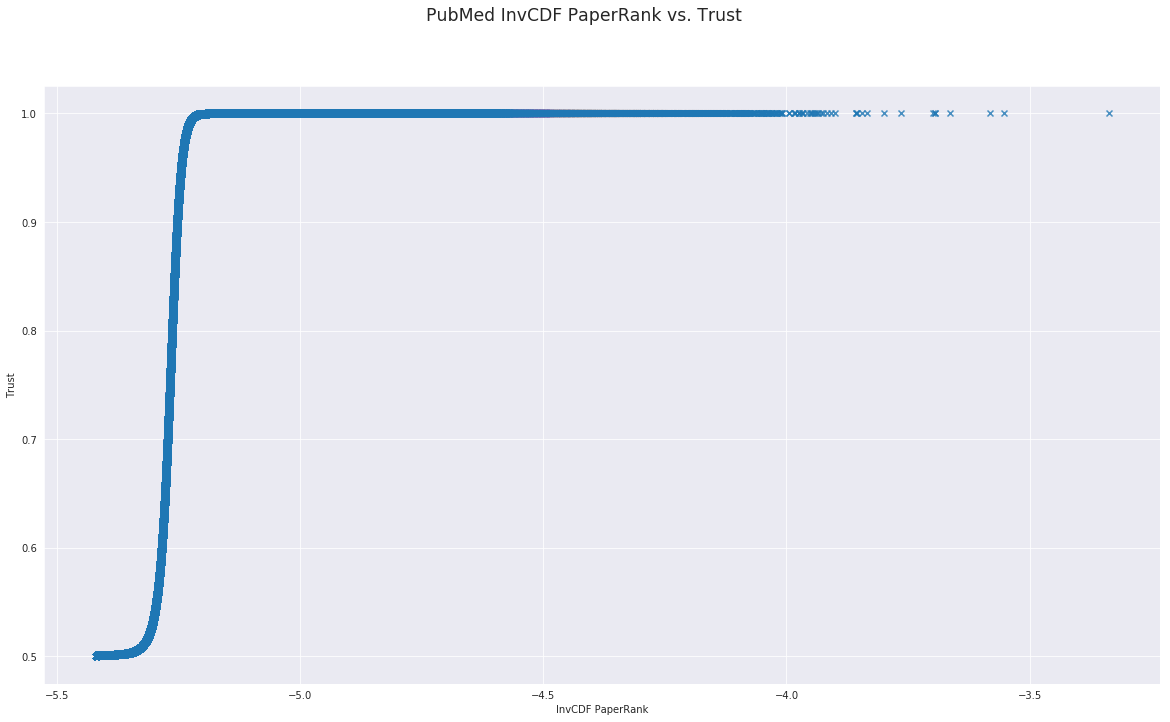

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank vs. Trust')
ax.set_xlabel('InvCDF PaperRank')
ax.set_ylabel('Trust')
sns.regplot(x=pr_invcdf, y=pr_trust_float, fit_reg=False, ax=ax, marker='x')

## K-Means Clustering Model

We also attempted to model the Inverse CDF PaperRank dataset to K-Means model with 3 clusters. We then used this to develop a *trust* score.

$$
{\displaystyle {\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}={\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}|S_{i}|\operatorname {Var} S_{i}}
$$

Specifically, we use the [`sklearn.cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) package to model the dataset. As with the [Bayesian Gaussian Mixture Model](#scrollTo=qw2yKYh2EDOA), we adopt 3 same 3 clusters, **A**, **B**, and **C**. 

### Model Training

In [0]:
# Training the model

# Input Data
X = np.array([pr_invcdf, pr_invcdf]).T

# Instantiating model
pr_kmeans_model = cluster.KMeans(n_clusters=3, init='k-means++')

# Training model on entire dataset
pr_kmeans_model_fit = pr_kmeans_model.fit(X)

# Predict over entire dataset
pr_kmeans_preds = pr_kmeans_model.predict(X)

#### Model Backup

This section contains code to save the model and related variables to the `PaperRank-Analysis/models` folder on Google Drive. This code can only be run by Collaborators.

*Note: If this throws an Exception, you may have to sign in again [here](#scrollTo=njsus7GqJic6).*

In [0]:
# Variables to save
save_items = {
    'pr_kmeans_model': pr_kmeans_model,
    'pr_kmeans_model_fit': pr_kmeans_model_fit,
    'pr_kmeans_preds': pr_kmeans_preds
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying to delete 3 files in the `models/` folder
Deleting file pr_kmeans_model_fit with ID 1xosftTgA6E07PVkoGlnqBp1Sy_Urd66M
Deleting file pr_kmeans_model with ID 1LpGkXAppI_Qqv2eInmy0_L_VLPuf6vos
Deleted 2 files in `models/` folder
Starting variable upload
Uploading file with variable pr_kmeans_model of size 57935282
Removing temporary file of 57935282 bytes
Uploaded variable to file pr_kmeans_model with ID 1IXtJzCfYEiI3wwjPmoXVyfFjmFBtoVM9
Uploading file with variable pr_kmeans_model_fit of size 57935282
Removing temporary file of 57935282 bytes
Uploaded variable to file pr_kmeans_model_fit with ID 1RX-LLEy0NKWEjQerhh4e72WD9-Je-PpA
Uploading file with variable pr_kmeans_preds of size 57934733
Removing temporary file of 57934733 bytes
Uploaded variable to file pr_kmeans_preds with ID 1npCHI4wKDUvTClsFr4b-ZeAhTxBsKzg5
Finished uploading 3 variables


### Model Parameters

This section contains the code to clean and display the model parameters.

In [36]:
pr_kmeans_centers = [i[0] for i in pr_kmeans_model.cluster_centers_]

# Sorting in ascending order to correspond to clusters A, B and C
pr_kmeans_centers = np.sort(pr_kmeans_centers)

# Computing counts in each category (list needs to be reordered)
unique, counts = np.unique(pr_kmeans_preds, return_counts=True)
u_counts = dict(zip(unique, counts))

pr_kmeans_centers_df = pd.DataFrame(pr_kmeans_centers,
                          index=['A', 'B', 'C'],
                          columns=['Cluster Center'])

pr_kmeans_centers_df['Count'] = u_counts.values()

# Computing ranges of each of the clusters
cluster_ranges = []

for i in range(0, 3):
  cluster_preds = pr_invcdf[np.argwhere(pr_kmeans_preds == i)]

  cluster_range = np.max(cluster_preds) - np.min(cluster_preds)
  
  cluster_ranges += [cluster_range]

pr_kmeans_centers_df['Cluster Range'] = cluster_ranges
  
pr_kmeans_centers_df

,Cluster Center,Count,Cluster Range
A,-5.404855,8138473,0.088600
B,-5.259480,5023574,0.175748
C,-5.053359,1321596,1.818842


### Model Visualization

This section contains code to visualize the model.

In [0]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank')
ax.set_xlabel('PubMed ID')
ax.set_ylabel('InvCDF PaperRank')
plt.scatter(pr_id, pr_invcdf, c=pr_kmeans_preds, cmap='RdYlGn')

## InvCDF K-Means Trust Score

This section contains code to compute a community *trust* score with the output of the [InvCDF PaperRank K-Means Clustering Model](#scrollTo=yuOxtnAzpeFr).

### Inverse Distance Computation

For the later use in the trust score, we compute the inverse distance from each of the clusters.

$$
\text{Let set of cluster centers} = \textbf{c}
$$

$$
\text{Inverse Distance of PaperRank $x$ from $k$,} = d(x, k) \\
d(x, k) =
\begin{cases}
    \frac{1}{\lvert x - k \rvert} \text{,} &\quad\text{if} \; x \neq k \\
    \infty \text{,} &\quad\text{if} \; x = k \\
\end{cases}
$$

**NOTE:** We must correct for the $\infty$ by setting the infinity values to 1 in the final probabilities.

In [221]:
pr_kmeans_invd = []

for center in pr_kmeans_centers:
  print(center)
  invd = [1 / fabs(i - center) for i in pr_invcdf]
  # Note np.finfo(np.float).max is the maximum possible np.float value
  invd = [i if not np.isinf(i) else np.finfo(np.float).max for i in invd]
  pr_kmeans_invd += [invd]
  
# Casting to np.array, and transposing for consistency and (N, 3) shape
pr_kmeans_invd = np.array(pr_kmeans_invd).T

-5.404854643946775
-5.259480307651501
-5.05335917083173


### Softmax Function

The softmax function is used to transform the inverse distances to probabilities.

$$
\text{Let probability PaperRank $x$ is in cluster $c_i$} = P(c = c_i | \, x) \\
P(c = c_i | \, x) = \frac{e^{d(x, c_i)}}{\sum_{k \in \textbf{c}} e^{d(x, k)}} \; \forall \, c_i \in \textbf{c}
$$


The probabilities correspond to the isolated membership probabilities of each publication in each of the 3 catgories, **A**, **B** and **C**. Speficially:

$$
P(A \cap (B \cup C)^\complement) \\
P(B \cap (A \cup C)^\complement) \\
P(C \cap (A \cup B)^\complement)
$$

We must also correct for values that may converge to infinity during computation. This is a result of the definition of $d(x, k)$. To correct this, we set all values that are infinity in `pr_kmeans_invd_exp` (the intermediary step) to the maximum possible value allowed by `numpy`, [`np.finfo(np.float).max`](https://stackoverflow.com/questions/1658714/range-of-valid-numpy-values).

In [0]:
# Computing exp(inverse distance)
pr_kmeans_invd_exp = np.array([np.exp(i) for i in pr_kmeans_invd])

# Correcting infinity by setting it to max value
pr_kmeans_invd_exp[np.isinf(pr_kmeans_invd_exp)] = np.finfo(np.float).max

# Computing softmax probabilities
pr_kmeans_softmax = np.array([i / np.sum(i) for i in pr_kmeans_invd_exp])

#### Softmax Backup

This section contains logic to back up the softmax probabilities.

In [152]:
# Variables to save
save_items = {
    'pr_kmeans_softmax': pr_kmeans_softmax
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying to delete 1 files in the `models/` folder
Deleting file pr_kmeans_softmax with ID 1KU2O-KeYsSP5Dab8zbwJIsTEi0L8mbNA
Deleted 1 files in `models/` folder
Starting variable upload
Uploading file with variable pr_kmeans_softmax of size 347607595
Removing temporary file of 347607595 bytes
Uploaded variable to file pr_kmeans_softmax with ID 1GHlksIQjeASClsyRQG7Bd0MjOByCnfSb
Finished uploading 1 variables


### Baseline Trust

To correctly scale our *trust* score, we must define a level of baseline trust, $P(T)$. This represents the baseline level of trust assumed to be inherent in each of the publications, as a result of them being published in peer reviewed journals.

Being a probability distribution, $P(T)$ ranges from 0 to 1. 0 represents no trust, and 1 represents complete trust.

we set the `baseline_trust` to 0.5. That is, we assume that the baseline level of trust by being published in a peer reviewed journal is neither trusted nor untrusted.

$$
P(T) = 0.5
$$

In [0]:
baseline_trust = 0.5

### Formula Derivation

We define the probability of trust to be the probability that a given pubication, $D$ is trusted.

<br>

$$
\text{Let probability of trust for a given publication} = P(T|D)
$$

<br>

Recall Bayes' theorem:

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

Applying this to the probability of trust, $P(T|D)$, we get:

$$
P(T|D) = \frac{P(D|T)P(T)}{P(D)}
$$

We can expand the probability of the $P(D)$ into its conditional components:

$$
P(D) = P(D|T)P(T) + P(D|T^\complement)P(T^\complement) \\
\text{But,} \; P(T^\complement) = 1 - P(T) \\
\Rightarrow P(D) = P(D|T)P(T) + P(D|T^\complement)(1-P(T))
$$

Substituting this into the Bayes' theorem expansion of $P(T|D)$:

<br>

$$
\therefore \; P(T|D) = \frac{P(D|T)P(T)}{P(D|T)P(T) + P(D|T^\complement)(1-P(T))}
$$

<br>

To compute the final trust metric for the $i^\text{th}$ page $\tau_i$, we must scale $P(T|D)$ by the baseline probability, $P(T)$

<br>

$$
\therefore \, \tau_i = P(T) + P(T | D)(1 - P(T))
$$

In [0]:
def computeTrust(pr_t: np.array, pr_nt: np.array,
                 baseline_trust: np.float) -> np.array:
  """Function to compute the trust score for a given set of
  membership probabilities of trusted and untrusted publications.
  
  Arguments:
    pr_t {np.array} -- List of probabilities that a publication is trusted.
    pr_nt {np.array} -- List of probabilities that a publication is not trusted.
  
  Returns:
    {np.array} -- List of trust values.
  """

  trust = np.empty_like(pr_t)
  
  # Flags
  count = 0
  decile = 1
  n = pr_t.size
  
  for i in range(len(pr_t)):
    unscaled_trust = (pr_t[i] * baseline_trust) / (pr_t[i] * baseline_trust + \
                      pr_nt[i] * (1 - baseline_trust))
    
    trust[i] = baseline_trust + (1 - baseline_trust) * unscaled_trust
  
    # Logging every 10%
    if int((count * 10) / n) == 1:
      print('Trust computation {}% complete'.format(decile * 10))
      decile += 1
      count = 0
    
    count += 1
  
  return trust

### Trust Categories

Utilizing the probabilities predicted in the Inverse CDF transformed PaperRank, we define:

$$
\text{Let} \; P(D|T) = P(C \cap (A \cup B)^\complement)
$$

This indicates that the probability of a given publication being trusted, $P(D|T)$ is equal to the probability it is a member of the third cluster (**C**, *Highly Trusted*).

Similarly, we define the probability of a given publication being not trusted, $P(D|T^\complement)$ to be the probability a publication is a member of the first (**A**, *Not Trusted*) or second cluster (**B**,  *Trusted*).

$$
\text{Let} \; P(D|T^\complement) = P((A \cup B) \cap C^\complement) \\
\text{Where} \;P((A \cup B) \cap C^\complement) = P(A \cap (B \cup C)^\complement) + P(B \cap (A \cup C)^\complement)
$$

In [0]:
pr_kmeans_t = np.copy(pr_kmeans_softmax[:,2])

pr_kmeans_nt = np.copy(pr_kmeans_softmax[:,0] + pr_kmeans_softmax[:,1])

### Trust Score Computation

In this section, we compute the trust score for each of the publications.

In [231]:
# Computing trust scores
pr_kmeans_trust = computeTrust(pr_t=pr_kmeans_t, pr_nt=pr_kmeans_nt,
                               baseline_trust=baseline_trust)

Trust computation 10% complete
Trust computation 20% complete
Trust computation 30% complete
Trust computation 40% complete
Trust computation 50% complete
Trust computation 60% complete
Trust computation 70% complete
Trust computation 80% complete
Trust computation 90% complete


#### Trust Score Backup

In this section, we backup the trust scores and relevant probabilities to Google Drive.

In [237]:
# Variables to save      
save_items = {
    'pr_kmeans_trust': pr_kmeans_trust,
    'pr_kmeans_t': pr_kmeans_t,
    'pr_kmeans_nt': pr_kmeans_nt
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying to delete 3 files in the `models/` folder
Deleting file pr_kmeans_nt with ID 1QiBo20sRfDopYFn-z_q7hF1RJQJ4mzcg
Deleting file pr_kmeans_t with ID 1moZ6GzcZhxLFgM6_POV0pPPjzGqdCnjC
Deleting file pr_kmeans_trust with ID 1DA_AAKYQtR6CYjcoZKXZoUKjrbr75yLc
Deleted 3 files in `models/` folder
Starting variable upload
Uploading file with variable pr_kmeans_trust of size 115869305
Removing temporary file of 115869305 bytes
Uploaded variable to file pr_kmeans_trust with ID 17Lsjdw1DZ5I-xgDVgEOK7g6SZg_cCi8Z
Uploading file with variable pr_kmeans_t of size 115869305
Removing temporary file of 115869305 bytes
Uploaded variable to file pr_kmeans_t with ID 1y_z2mHYh7kXI7fd82DxXpuhTpGczTArX
Uploading file with variable pr_kmeans_nt of size 115869305
Removing temporary file of 115869305 bytes
Uploaded variable to file pr_kmeans_nt with ID 1vyUwgXnhRQD9Ab4XPIL0uUnzwiqpgckE
Finished uploading 3 variables


### Trust Statistics

This section contains descriptive statistics for the K-Means trust score distribution.

In [191]:
pr_kmeans_trust_stats = computeDescriptiveStatistics(pr_kmeans_trust)

displayDescriptiveStatistics(stats=pr_kmeans_trust_stats,
                             name='PubMed PaperRank Trust')

,PubMed PaperRank Trust
mean,5.451144e-01
sd,1.382288e-01
var,1.910721e-02
skew,2.849481e+00
kurtosis,6.260348e+00
median,5.000000e-01
min,5.000000e-01
max,1.000000e+00
range,5.000000e-01
N,1.448364e+07


### Trust Distribution Plots

This section contains plots of the InvCDF PaperRank K-Means trust distribution.

#### Histogram

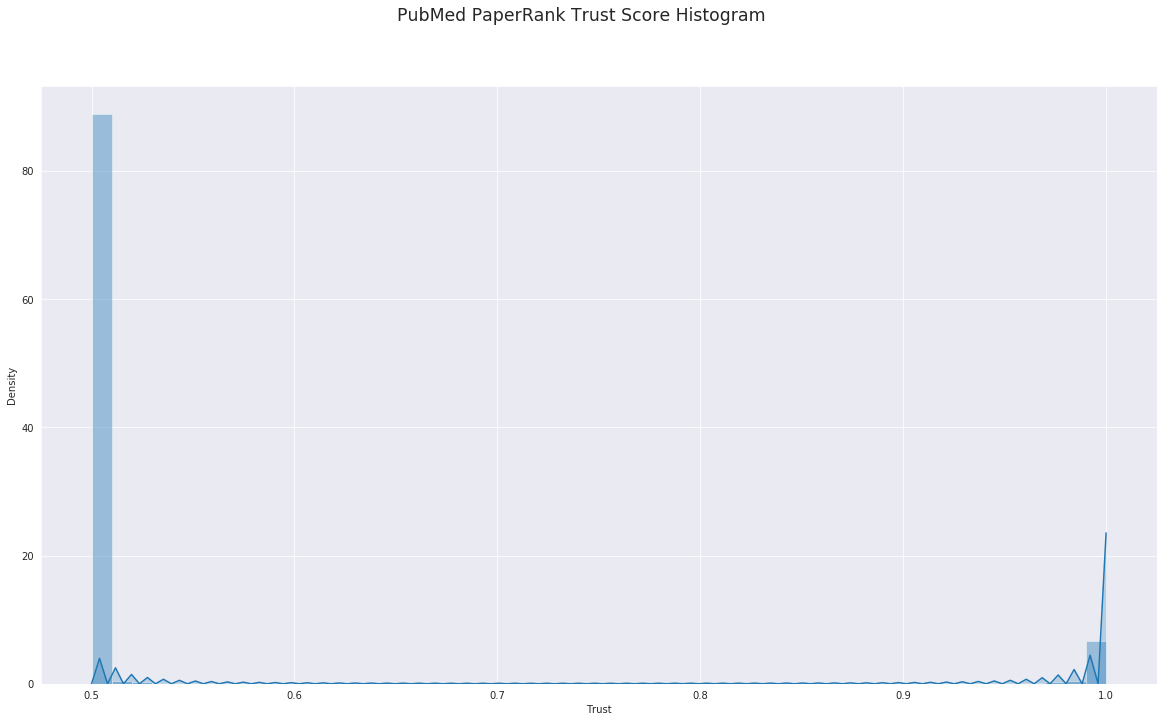

In [162]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Trust Score Histogram')
ax.set_xlabel('Trust')
ax.set_ylabel('Density')
sns.distplot(pr_kmeans_trust, kde=True, rug=False,
             kde_kws={'shade': True}, ax=ax)

#### Scatterplot

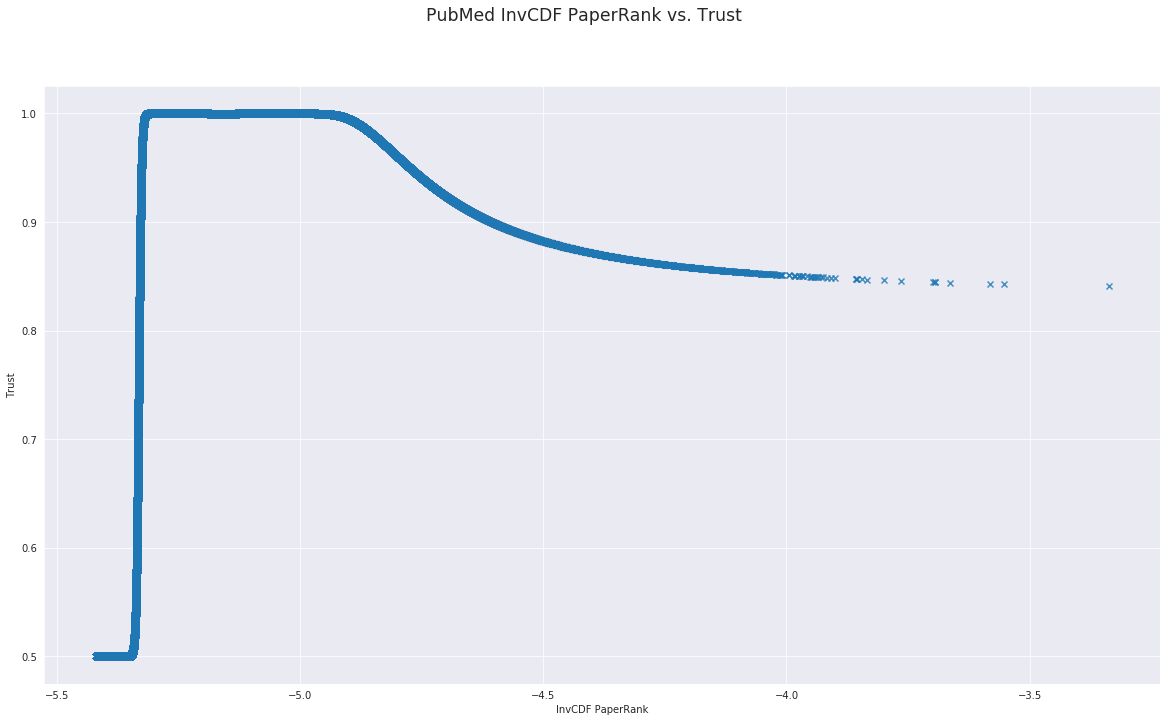

In [229]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank vs. Trust')
ax.set_xlabel('InvCDF PaperRank')
ax.set_ylabel('Trust')
sns.regplot(x=pr_invcdf, y=pr_kmeans_trust, fit_reg=False, ax=ax, marker='x')

### Discussion

As seen in the histogram above, the current instantiation of the K-Means Trust Score on the InvCDF PaperRank was not a good fit. Unfortunately, this is due to the [inverse distance computation function](#scrollTo=I8tZGD5336xV). The inverse of the modulus leads to an asymptotic graph. Plugging this into the softmax, this leads to a significant number of the group membership probabilities to converge to 1. Additionally, the inverse distance metric does not adequately *dampen* the membership in the **A** and **B** categories, when predicting membership probabilities for a point toward the right side of the **C** cluster.

See [this document](https://drive.google.com/file/d/1USckOJ74AXkk03cCeOeGEf8V02ivioT-/view?usp=sharing) for more information and some basic illustrations.

## InvCDF Gamma Model

In this section, we train a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) mixture model, using the Inverse CDF transformed PaperRanks.

### Gamma Distribution

The [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is a two-parameter family of continuous probability distributions. The exponential distribution is a special case of this distribution.

The Gamma Distribution has two parameterizations; one with shape parameter $\alpha$ and rate parameter $\beta$, and another with shape parameter $k$ and scale parameter $\theta$. The relationship between these two parameterizations is as follows:

$$
\text{Shape parameter,} \; \alpha = k \\
\text{Rate parameter,} \; \beta = \frac{1}{\text{Scale parameter}} = \frac{1}{\theta}
$$

The [`scipy.stats.gamma`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) module implements the Gamma distribution probability density function (PDF) with the shape $k$ and scale $\theta$ parameterization, so this is what we will use.

The following is the definition for the PDF of a gamma-distributed random variable $X$ with shape $k$ and scale $\theta$.

$$
X \sim \Gamma(k, \theta) \equiv \text{Gamma}(k, \theta) \\
\, \\
f(x; k, \theta) = \frac{x^{k-1} e^{-\frac{x}{\theta}}}{\theta^k \Gamma(k)} \; \forall \; \{x, k, \theta\} \in \mathbb{R}_{>0} \\
\, \\
\, \\
\text{Where $\Gamma(a)$ is the Gamma Function.} \\
\Gamma(a) = \int_0^\infty x^{a-1}e^{-x} \, dx \; \forall \; a \in \{ \mathbb{R} \setminus \mathbb{N}_{\leq 0} \}
$$

### Gamma Distribution Analysis

The Gamma Distribution has an interesting behavior that allows it to generalize many distribution characteristics. This includes variable skew and kurtosis, which are useful to approximate the power-distribution like behavior of the **C** category, and the extremely high kurtosis of **A** (see [InvCDF PaperRank Histogram](#scrollTo=zp4VNTlIDLHy)).

In this section, we define the first four moments of the Gamma distribution with respect to the shape $k$ and scale $\theta$, and explore the behavior of the Gamma distribution with respect to its parameters.

#### Distribution Moments

In the Gamma distribution, the [first four moments](https://en.wikipedia.org/wiki/Moment-generating_function) of the distribution can be computed using just the shape $k$ and scale $\theta$ parameters.

$$
\text{Mean,} \; \mu = E[X] = k \theta \\
\text{Variance,} \; \sigma^2 = \text{Var}[X] = k \theta^2 \\
\text{Skewness}  = \frac{2}{\sqrt{k}} \\
\text{Excess kurtosis} = \frac{6}{k}
$$

#### Behavior Analysis

The behavior of the Gamma distribution varies widely with the configuration of the shape $k$ and scale $\theta$ parameters.

- For an interactive demo of the behavior of the gamma distribution with respect to the shape $k$ and scale $\theta$, see [this interactive visualization](https://www.geogebra.org/graphing/gfx3jbsx).

- For an behavior overview, consider the following graph:

![](https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg =400x)
> Image Source: [Wikimedia Commons](https://en.wikipedia.org/wiki/File:Gamma_distribution_pdf.svg)

- The following graph highlights the range of behaviors the Gamma distribution can capture, with respect to the shape $k$ and scale $\theta$ parameters.

![](https://upload.wikimedia.org/wikipedia/commons/c/cb/Gamma-PDF-3D-by-x.png =x500)

> Image Source: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Gamma-PDF-3D-by-x.png)

### Generalized EM Algorithm

In this section, we derive the general form of the [Expectation Maximization (EM)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) algorithm.

The following formulation of the Generalized [Expectation-Maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) is based on the following sources:

- Stanford University Course [CS 229 (Machine Learning)](http://cs229.stanford.edu/) - Lecture 8 (*Expectation Maximization*), taught by [Andrew Ng](http://www.andrewng.org/) and [Dan Boneh](http://crypto.stanford.edu/~dabo/).
  - [Lecture Notes](http://cs229.stanford.edu/notes/cs229-notes8.pdf)
  - [Lecture Recording](https://www.youtube.com/watch?v=ZZGTuAkF-Hw)
- Derek Young's R [`mixtools`](https://cran.r-project.org/web/packages/mixtools/index.html) package.
  - [`mixtools.gammamixEM.R`](https://github.com/cran/mixtools/blob/master/R/gammamixEM.R)
  - [CRAN - `mixtools`](https://cran.r-project.org/web/packages/mixtools/index.html)
  - [mixtools: An R Package for Analyzing Finite
Mixture Models](http://personal.psu.edu/drh20/papers/mixtools.pdf) - Benaglia, et al.

#### Motivation

Consider the following scenario:
- We have some **joint probability distribution model**, $P(x, z; \theta)$
- We observe only $x$
- We want to compute the **membership probabilities** of $x$ in each of the distributions, and compute their **model parameters**.

#### Variable Definitions

$$
\text{Let number of mixture distributions} = m : \{ m \in \mathbb{N}_{>0} \} \\
\text{Let number of model parameters} = \alpha : \{ \alpha \in \mathbb{N}_{>0} \} \\
\text{Let number of observations} = n : \{ n \in \mathbb{N}_{>0} \} \\
\; \\
\text{Let observations vector $(n \times 1)$} = \boldsymbol{x} \\
\text{Let $i^\text{th}$ observation} = x^{(i)} \\
\; \\
\text{Let matrix of mixture distribution parameters $(m \times \alpha )$} = \theta \\
\text{Let vector of distribution parameters of $j^\text{th}$ distribution $(\alpha \times 1)$} = \boldsymbol{\theta_j} \\
\; \\
\text{Let latent (i.e. hidden/unobserved) random variable} = z \\
\text{Let $x^{(i)}$ and $z^{(i)}$ have a joint probability distribution,} \; P(x^{(i)}, z^{(i)}) \\
\Rightarrow P(x^{(i)}, z^{(i)}) = P(x^{(i)} | z^{(i)}) \cdot P(z^{(i)}) \\
\text{We assert} \; z^{(i)} \sim \text{Multinomial}(m) \equiv Q_i \\
\; \\
\text{We assert that $x^{(i)}$ conditioned on $z^{(i)} = j$ is a probability distribution with parameters $\boldsymbol{\theta_j}$} \\
x^{(i)} | (z^{(i)} = j) \sim \text{Distribution}(\boldsymbol{\theta_j}) \; \forall j \in \{ 1, \dots, m \} \\
\text{Let} \; P(z_j^{(i)}) = P(z^{(i)} = j) \; \forall j \in \{ 1, \dots, m \}
$$

#### Membership Probabilities

Using the notation described [above](#scrollTo=33p2Bi3EsPTs), we can now define relationships between the joint distribution of $x^{(i)}$ and $z^{(i)}$.

$$
P(x^{(i)}, z_j^{(i)} ; \boldsymbol{\theta_j}) = P(x^{(i)} | z_j^{(i)} ; \boldsymbol{\theta_j}) \cdot P(z_j^{(i)}; \boldsymbol{\theta_j}) \; \forall j \in \{ 1, \dots, m \} \\
\text{We can expand this using the assertions above:} \\
\Rightarrow P(x^{(i)} | z_j^{(i)} ; \boldsymbol{\theta_j}) = \text{Distribution}(x^{(i)}; \boldsymbol{\theta_j})
$$

#### Mixture Proportions

To correctly scale the probability of $x^{(i)}$ in each of the mixture distributions, we must scale them by the corresponding mixture proportion, $\lambda_j$.

$$
\text{Let mixture proportions vector $(m \times 1)$} = \boldsymbol{\lambda} \\
\text{Let mixture proportion of $j^{\text{th}}$ mixture distribution} = \lambda_j \\
\; \\
\Rightarrow \lambda_j = \frac{1}{n} \sum_{i=1}^n P(z^{(i)} | x^{(i)}; \boldsymbol{\theta_j}) \; \forall j \in \{ 1, \dots, m \}
$$

#### Mixture Distribution Density

Using the mixture proportion calculated above, we can generalize the value of the probability of $x^{(i)}$ in each of the distributions:

$$
P(x^{(i)}; \theta) = \sum_{j=0}^m \lambda_j P(x^{(i)}; \boldsymbol{\theta_j})
$$

#### Log Likelihood

We can now define the **log likelihood** of the probability our data, $\boldsymbol{x}$ with model parameters $\theta$:

$$
\mathcal{L}(\theta)
= \log P(\boldsymbol{x} \, ; \theta)
= \log \sum_{i=1}^n P(x^{(i)} ; \theta) \\
\text{We can express $P(x^{(i)}; \theta)$ as the sum of its marginal components} \\
\Rightarrow \mathcal{L}(\theta)
= \log \sum_{i=1}^n P(x^{(i)} ; \theta)
= \sum_{i=0}^n \log \sum_{j=0}^m P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j}) \\
\; \\
\text{We divide and multiply by the same factor, $Q_i(z_j^{(i)})$} \\
\Rightarrow \sum_{i=0}^n \log \sum_{j=0}^m P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})
= \sum_{i=0}^n \log \sum_{j=0}^m Q_i({z_j^{(i)}}) \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})} \\
\text{Where $Q_i$ is a valid probability distribution,} \; \left[ Q_i(z_j^{(i)}) \geq 0; \sum_{j=0}^m Q_i(z_j^{(i)}) = 0, \; \forall j \in \{ 1, \dots, m \} \right] \\
\; \\
\; \\
\text{We know from probability theory that for a random variable $z \sim P$ and function $g(z)$:} \\
\expec_{z \sim P}[g(z)] = \sum_z P(z) \cdot g(z) \\
\; \\
\text{We apply the same logic to the formula above:} \\
\Rightarrow \log \sum_{j=0}^m Q_i({z_j^{(i)}}) \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})}
= \log \expec_{z^{(i)} \sim Q_i} \left[ \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})} \right] \\
\; \\
\; \\
\text{Plugging this into our original function, $\mathcal{L}(\theta)$:} \\
\Rightarrow \mathcal{L}(\theta) = \sum_{i=0}^n \log \expec_{z^{(i)} \sim Q_i} \left[ \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})} \right] \\
\; \\
\; \\
\text{From $\href{https://en.wikipedia.org/wiki/Jensen%27s_inequality}{\text{Jensen's Inequality}}$, we know that for the concave log function:} \\
\log (\expec[X]) \geq \expec[\log(X)] \\
\text{We can construct a $\textit{lower bound}$ for the log likelihood of $Q_i$:} \\
\sum_{i=0}^n \log \expec_{z^{(i)} \sim Q_i} \left[ \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})} \right] \geq \sum_{i=0}^n \expec_{z^{(i)} \sim Q_i} \left[ \log \left( \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})} \right) \right] \\
\Rightarrow \mathcal{L}(\theta) \geq \sum_{i=0}^n \expec_{z^{(i)} \sim Q_i} \left[ \log \left( \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})} \right) \right]
= \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})}
$$

<br>

However for the EM algorithm to work, we must enforce **strict equality** between the log likelihood and the lower bound constructed above. This is achieved when we have a constant expectation of the distribution $Q_i$.

$$
\text{We want:} \; \frac{P(x^{(i)}, z_j^{(i)} ; \boldsymbol{\theta_j)}}{Q_i(z_j^{(i)})} = C, C \in \mathbb{R} \; \forall j \in \{ 1, \dots, m \} \\
\; \\
\begin{aligned}
  \Rightarrow \text{We need $Q_i$ such that:} \; & Q_i(z_j^{(i)}) \propto P(x^{(i)}, z_j^{(i)} ; \boldsymbol{\theta_j}) \\
  & \sum_{j=0}^m Q_i(z_j^{(i)}) = 1
\end{aligned}
$$

This behavior can be achieved by normalizing each of the probabilities to sum to 1:

$$
\Rightarrow Q_i(z_j^{(i)})
= \frac{P(x^{(i)}, z_j^{(i)} ; \boldsymbol{\theta_j})}{\sum_{k=0}^m P(x^{(i)}, z_k^{(i)} ; \boldsymbol{\theta_k})}
= \frac{P(x^{(i)}, z_j^{(i)} ; \boldsymbol{\theta_j})}{\sum_{k=0}^m P(x^{(i)}, z_k^{(i)} ; \boldsymbol{\theta_k})} \\
\text{By definition,} \; \sum_{k=0}^m P(x^{(i)}, z_k^{(i)} ; \boldsymbol{\theta_k}) = P(x^{(i)} ; \theta) \\
\therefore \; Q_i(z_j^{(i)}) = \frac{P(x^{(i)}, z_j^{(i)} ; \boldsymbol{\theta_j})}{P(x^{(i)} ; \theta)} = P(z_j^{(i)} | x^{(i)}; \boldsymbol{\theta_j}) \; \forall j \in \{ 1, \dots, m \}
$$

<br>

Following this definition of $Q_i$, we can define the full log likelihood function:

$$
\mathcal{L}(\theta) = \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})}
$$

This formula can be simplified further by substituting the formula for $Q_i(z_j^{(i)})$

$$
\Rightarrow \mathcal{L}(\theta)
= \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})}{Q_i(z_j^{(i)})}
= \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log \frac{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j}) \cdot P(x^{(i)} ; \theta)}{P(x^{(i)}, z_j^{(i)}; \boldsymbol{\theta_j})} \\
= \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log P(x^{(i)} ; \theta)
= \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log (\lambda_j P(x^{(i)}; \boldsymbol{\theta_j}))
$$

Thus, we have derived the full log likelihood function to be maximized:

$$
\therefore \; \mathcal{L}(\theta) = \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log (\lambda_j P(x^{(i)}; \boldsymbol{\theta_j}))
$$

#### Complete EM Algorithm

Utilizing the formulas and notation derived above, the full generalized Expectation Maximization (EM) algorithm can be defined:

**DO:**

1. **E-Step**: Expectation Step

$$
\text{Set} \; \hat{Q_i(z_j^{(i)})} := P(z^{(i)} | x^{(i)} ; \boldsymbol{\theta_j}) \; \forall \; i \in \{1, \dots, n\}; \, j \in \{1, \dots, m\} \\
\text{Set} \; \hat{\lambda_j} := \frac{1}{n} \sum_{i=0}^n Q_i(z_j^{(i)}) \; \forall j \in \{ 1, \dots, m \}
$$

2. **M-Step**: Maximization Step

$$
\text{Set} \; \hat{\theta} := \argmax_{\theta} \mathcal{L}(\theta) = \argmax_{\theta} \sum_{i=0}^n \sum_{j=0}^m \hat{Q_i(z_j^{(i)})} \log (\hat{\lambda_j} P(x^{(i)}; \boldsymbol{\theta_j}))
$$

**WHILE:** 

$$
|| \mathcal{L}(\theta) - \mathcal{L}(\hat{\theta}) || > \epsilon
$$

### Implementation

This section contains the implementation of the model described above.

#### Positivity Constraint

Recall from the [Gamma distribution definition](#scrollTo=trYENLN9fOqL) that it is only defined for data $x : x \in \mathbb{R}_{>0}$.

When estimating the initial parameter values of the mixture model Gamma distributions (discussed extensively in this section), the Inverse CDF PaperRank is transformed by shifting it by the absolute value of the minimum InvCDF PaperRank (i.e. `pr_invcdf + np.absolute(np.min(pr_invcdf))`), and adding an arbitrary `gamma_shift_constant` (default 0.05; chosen due to ideal rounding of the resulting model parameters) to enforce strict positivity.

In [0]:
gamma_shift_constant = 0.01

The following implements the transformation described above.

In [0]:
def shiftPR(ranks: np.array, shift: np.float=gamma_shift_constant) -> tuple:
  """Function to transform a negative score distribution to enforce strict
  positivity. This is done by shifting the entire dataset by the absolute
  of the minimum value, and adding an arbitrary `shift` to
  enfore strict positivity.
  
  Arguments:
    ranks {np.array} -- Vector of ranks to be shifted.
    
  Keyword Arguments:
    shift {np.float} -- Arbitrary value to shift data to enforce
                        strict positivity (default: {gamma_shift_constant}).

  Returns:
    {tuple} -- Tuple of type (np.array, np.float), with the the shifted data,
               and the `shift` used to shift the data, respectively.
  """
  
  # Computing shifted ranks, using the formula above
  shifted_ranks = ranks + np.absolute(np.min(ranks)) + shift
  
  return (shifted_ranks, shift)

The following section computes the Abs Shifted InvCDF PaperRank and explores the distribution characteristics.

In [0]:
pr_invcdf_s, _ = shiftPR(ranks=pr_invcdf)

##### Histogram

Histogram of the Abs Shifted InvCDF PaperRank.

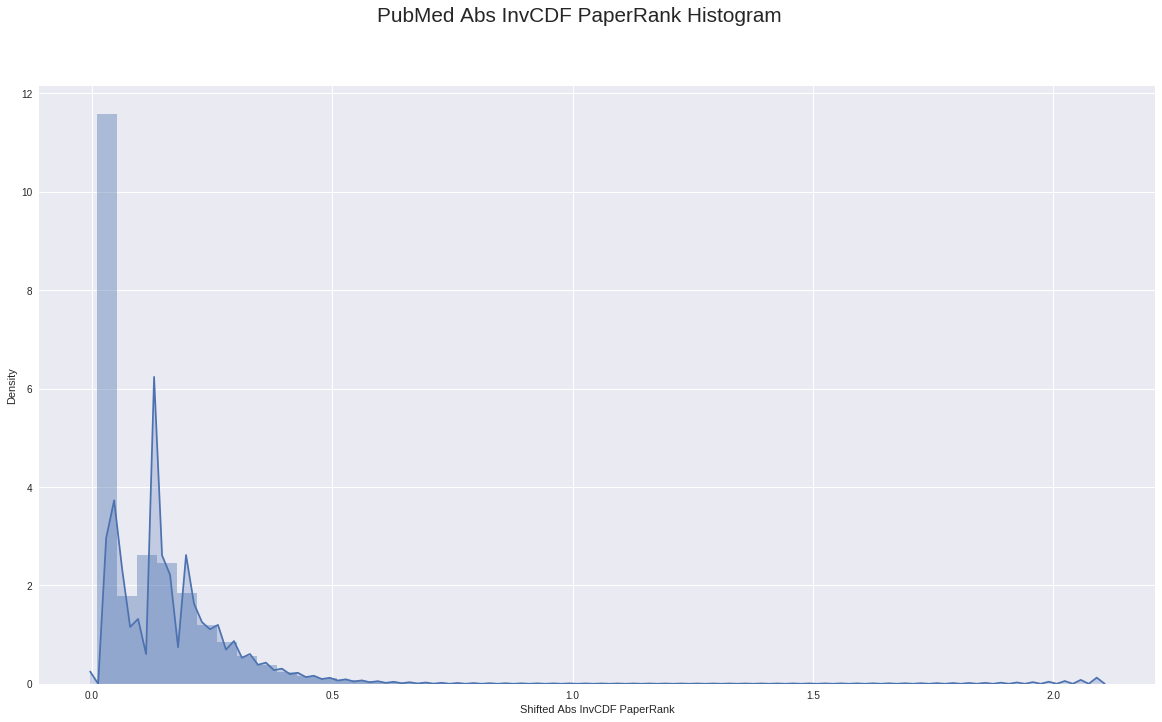

In [222]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Abs InvCDF PaperRank Histogram')
ax.set_xlabel('Shifted Abs InvCDF PaperRank')
ax.set_ylabel('Density')
sns.distplot(pr_invcdf_s, kde=True, rug=False,
             kde_kws={'shade': True}, ax=ax)

##### Descriptive Statistics

This section contains descriptive statistics for the Abs Shifted InvCDF PaperRanks, `pr_invcdf_s`.

In [223]:
pr_invcdf_s_stats = computeDescriptiveStatistics(pr_invcdf_s)

displayDescriptiveStatistics(stats=pr_invcdf_s_stats,
                             name='Shifted Abs InvCDF PaperRank')

,Shifted Abs InvCDF PaperRank
mean,1.083625e-01
sd,1.173718e-01
var,1.377613e-02
skew,1.653183e+00
kurtosis,4.003054e+00
median,5.803507e-02
min,1.000000e-02
max,2.093190e+00
range,2.083190e+00
N,1.448364e+07


#### Density Computation

This section implements the density computation for the Gamma distribution.

To do this, we use the `scipy.stats.gamma.pdf` function from the [`scipy.stats.gamma`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) module.

From the documentation, we know that this function takes 4 arguments, `x` (the data), `a` (the shape parameter), `loc` (location shift), and `scale` (the scale parameter).

Further, the documentation also asserts that `gamma.pdf(x, a, loc, scale)` = `gamma.pdf(y, a) / scale` with `y = (x - loc) / scale`. Here, we show that (in the notation described [above](#scrollTo=trYENLN9fOqL)); `a` $= k$, `s` $= \theta$, and `loc` $= 0$.

$$
\text{Let} \; \texttt{a} = k \\
\text{Let} \; \texttt{s} = \theta \\
\text{Let} \;\texttt{loc} = l \\
\text{Let} \; \texttt{x} = x \\
$$

$$
\text{Let} \; \texttt{y} = y \\
\text{Where} \; y = \frac{x - l}{s}
$$

<br>

$$
\text{Let} \; f(x ; a) = \frac{x^{a-1} e^{-x}}{\Gamma(a)} \\
\text{Where} \; \Gamma(a) = \int_0^\infty z^{a-1} e^{-a} dz
$$

We know from the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) for the function `gamma.pdf` that:

$$
\;
f(x; a) = \frac{f(y; a)}{s} \\
\; \\
\text{RHS} \Rightarrow \frac{f(y; a)}{s}
= \frac{f \left( \frac{x - l}{s}; a \right)}{s}
= \frac{1}{s} \cdot \frac{\left( \frac{x-l}{s} \right)^{a-1} \exp{\left[{- \left(\frac{x-l}{s} \right)} \right]}}{\Gamma(a)}
= \frac{\left( \frac{x-l}{s} \right)^{a-1} \exp{\left[{- \left(\frac{x-l}{s} \right)} \right]}}{s \cdot \Gamma(a)} \\
= \frac{( x-l )^{a-1} s^{-(a-1)} \exp{\left[{- \left(\frac{x-l}{s} \right)} \right]}}{s \cdot \Gamma(a)}
= \frac{( x-l )^{a-1} \exp{\left[{- \left(\frac{x-l}{s} \right)} \right]}}{ s^{a-1} \cdot s \cdot \Gamma(a)}
= \frac{( x-l )^{a-1} \exp{\left[{- \left(\frac{x-l}{s} \right)} \right]}}{ s^a \cdot \Gamma(a)} \\
\; \\
\therefore \; f(x; a) = \frac{( x-l )^{a-1} \exp{\left[{- \left(\frac{x-l}{s} \right)} \right]}}{ s^a \cdot \Gamma(a)}
$$

Note that we already shift the data in the [*Positivity Constraint*](#scrollTo=cyfcwHCDogI9) section. Thus, we can ignore the locational scaling parameter (`loc`, $l$) in our formulation by setting it to zero.

$$
\text{With} \; l = 0 \\
\;
\Rightarrow f(x;a)|_{l=0}
= \frac{x^{a-1} \exp{\left[{- \left(\frac{x}{s} \right)} \right]}}{ s^a \cdot \Gamma(a)}
$$

This is equivalent to the [parametrization of the Gamma distribution with shape $k$ and scale $\theta$](#scrollTo=trYENLN9fOqL):

$$
\begin{aligned}
  \text{With:} \; & a = k \\
  & s = \theta \\
  & l = 0 
\end{aligned} \\
\; \\
\therefore \;  f(x; k, \theta)
= \frac{x^{k-1} e^{-\frac{x}{\theta}}}{\theta^k \Gamma(k)}
= f(x; a)
= \frac{x^{a-1} e^{- \frac{x}{s}} }{ s^a \Gamma(a)} \\
$$

Using this equivalence, we can define the following function to compute probability densities for data `x`, with shape parameter `shape`, and scale parameter `scale` using the [`scipy.stats.gamma.pdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) function.

$$
\texttt{computeGammaPDF}(\texttt{x}=x, \texttt{shape}=k, \texttt{scale}=\theta) = f(x; k, \theta) = \frac{x^{k-1}e^{-\frac{x}{\theta}}}{\theta^k \Gamma(k)}
$$

In [0]:
def computeGammaPDF(x: np.array, shape: np.float,
                    scale: np.float, loc: np.float) -> np.array:
  """Function to compute Gamma distribution probabilities for data `x`, with
  shape parameter `shape`, and scale parameter `scale`. This assumes the Gamma
  distribution uses the shape $k$, and scale $\theta$ formulation.
  See: https://en.wikipedia.org/wiki/Gamma_function
  
  Arguments:
    x {np.array} -- Array of data.
    shape {np.float} -- Shape parameter for the gamma distribution.
    scale {np.float} -- Scale parameter for the gamma distribution.
    loc {np.float} -- Location parameter for the gamma distribution.
  
  Returns:
    {np.array} -- Array of Gamma distribution probabilities.
  """
  
  return stats.gamma.pdf(x=x, a=shape, scale=scale, loc=loc)

#### Scaled Density Computation

In the [Expectation Maximization algorithm](#scrollTo=LyFZ0pLU8t38), we must compute scaled densities in each of the mixture distributions. That is, we require the value of the Gamma distributed data $\boldsymbol{x}$, with Gamma distribution parameters $\left( \boldsymbol{\theta_j} = \left[ k_j \; \theta_j \right]\right)$ corresponding to each of the mixture distributions, scaled by its corresponding mixture density, $\lambda_j \; \forall j \in \{1 ,\dots, m\}$.

$$
\texttt{computeScaledGPDF}(\texttt{x}=x, \texttt{params}=\boldsymbol{\theta}, \texttt{weights}=\boldsymbol{\lambda})
= 
\begin{bmatrix}
  \lambda_1 \cdot f(x; k_1, \theta_1) \\
  \vdots \\
  \lambda_m \cdot f(x; k_m, \theta_m) 
\end{bmatrix}^{\; \intercal} \\
\;
\begin{aligned}
  \text{Where:} \; & \boldsymbol{\theta} =
    \begin{bmatrix}
      k_1 & \theta_1 \\
      \vdots & \vdots \\
      k_m & \theta_m
    \end{bmatrix} \\
    \; \\
    & \boldsymbol{\lambda} =
      \begin{bmatrix}
        \lambda_1 \\
        \vdots \\
        \lambda_m
      \end{bmatrix}
\end{aligned}
$$

In [0]:
def computeScaledGPDF(x: np.array, params: np.ndarray, weights: np.array,
                      loc: np.float) -> np.array:
  """Function to compute scaled Gamma distribution posterior probabilities,
  given a set of model parameters, and corresponding mixture weights.
  
  Arguments:
    x {np.array} -- Array of data.
    params {np.ndarray} -- Matrix of Gamma distribution parameters, with each
                           row corresponding to a model, with the first column
                           being shape parameter $k$, and the second column
                           being scale parameter $\theta$.
    weights {np.array} -- Array of mixture weights.
  
  Returns:
    {np.ndarray} -- Scaled posterior Gamma distribution probabilities.
  """
  
  # Compute scaled gamma (note: list comprehension for speed)
  scaled_gamma = [weights[i] * computeGammaPDF(x=x,
                                               shape=params[i][0],
                                               scale=params[i][1],
                                               loc=loc)
                  for i in range(weights.size)]
  
  # Cast to np.ndarray, return
  return np.array(scaled_gamma)

#### Membership Probabilities

We require the posterior membership probabilities in each of the distributions, $Q$ (a $(n \times m)$ matrix), for each of the publications.

$$
\text{Let posterior membership probabilities} = Q \\
\Rightarrow Q_{i,j}
= \frac{\lambda_j P(x_i | \boldsymbol{\theta_j})}{\sum_{k=0}^m \lambda_k P(x_i | \boldsymbol{\theta_k})} \; \forall \; i \in \{1, \dots, n\}; \; j \in \{ 1, \dots, m \} \\
\; \\
\therefore \; Q =
\begin{bmatrix}
  \frac{\lambda_1 P(x^{(1)} | \boldsymbol{\theta_1})}{\sum_{k=0}^m \lambda_k P(x^{(1)} | \boldsymbol{\theta_k})} & \cdots & \frac{\lambda_m P(x^{(1)} | \boldsymbol{\theta_m})}{\sum_{k=0}^m \lambda_k P(x^{(1)} | \boldsymbol{\theta_k})} \\
  \vdots & \ddots & \vdots \\
  \frac{\lambda_1 P(x^{(n)} | \boldsymbol{\theta_1})}{\sum_{k=0}^m \lambda_k P(x^{(n)} | \boldsymbol{\theta_k})} & \cdots & \frac{\lambda_m P(x^{(n)} | \boldsymbol{\theta_m})}{\sum_{k=0}^m \lambda_k P(x^{(n)} | \boldsymbol{\theta_k})}
\end{bmatrix}
$$

In [0]:
def computeMembership(scaled_gpdf: np.ndarray) -> np.ndarray:
  """Function to compute posterior membership probabilities, given the scaled
  Gamma distribution probabilities for each of the mixture distributions.
  
  Arguments:
    scaledGPDF {np.ndarray} -- Scaled Gamma distribution values for each of the
                               mixture distributions.
  
  Returns:
    {np.ndarray} -- Posterior membership probabilities in each of the
                    mixture distributions.
  """

  # Computing sum (by row)
  agg = np.sum(scaled_gpdf, axis=0)
  
  # Compute posterior, return
  return scaled_gpdf / agg

#### Mixture Proportions

We require the mixture proportions in each of the distributions, $\boldsymbol{\lambda}$.

The mixture proportion for a given mixture distribution $j$ is defined as follows:

$$
\text{Let mixture proportion for distribution $j$} = \lambda_j \\
\Rightarrow \lambda_j = \frac{1}{n} \sum_{i=0}^n Q_{i, j} \; \forall j \in \{1, \dots, m\} \\
\therefore \, \lambda =
\begin{bmatrix}
  \frac{1}{n} \sum_{i=0}^n Q_{i, 1} \\
  \vdots \\
  \frac{1}{n} \sum_{i=0}^n Q_{i, m}
\end{bmatrix}
$$

In [0]:
def computeMixtureProps(mem_posterior: np.ndarray) -> np.array:
  """Function to compute the mixture proportions of each of the mixture
  distributions.
  
  Arguments:
    memPosterior {np.ndarray} -- Matrix of posterior membership probabilities.
    
  Returns:
    {np.array} -- Mixture proportions for each of the mixture distributions.
  """
  
  # Compute mean by row, return
  return np.mean(mem_posterior, axis=1)

#### Log Likelihood

This section implements the log likelihood function [derived above](#scrollTo=DUNpYf4fsY63).

$$
\mathcal{L}(\theta) = \sum_{i=0}^n \sum_{j=0}^m Q_i(z_j^{(i)}) \log (\lambda_j P(x^{(i)}; \boldsymbol{\theta_j}))
$$

In [0]:
def computeLogLikelihood(x: np.array, params: np.ndarray, weights: np.array,
                         mem_prob: np.ndarray, loc: np.float) -> np.float:
  """Function to compute the log likelihood of the mixture model.
  
  Arguments:
    x {np.array} -- Vector of data.
    params {np.ndarray} -- Matrix of mixture distribution parameters.
    weights {np.array} -- Vector of mixture proportions.
    mem_prob {np.ndarray} -- Matrix of posterior membership probabilities in
                             each of the distributions.

  Returns:
    {np.float} -- Sum of the log likelihood.
  """
  
  prob = computeScaledGPDF(x=x, params=params, weights=weights, loc=loc)

  return np.sum(mem_prob * np.log(prob))

#### Log Likelihood Maximization

This section implements the maximization of the log likelihood function defined [above](#scrollTo=DUNpYf4fsY63).

In [0]:
def argmaxLL(x: np.array, params: np.ndarray, weights: np.array,
             mem_prob: np.ndarray, loc: np.float) -> np.ndarray:
  """Function to minimize the log likelihood function, given a set of
  parameters, weights and membership probabilities.
  
  Arguments:
    x {np.array} -- Vector of data.
    params {np.ndarray} -- Matrix of mixture distribution parameters.
    weights {np.array} -- Vector of mixture proportions.
    mem_prob {np.ndarray} -- Matrix of posterior membership probabilities
                             in each of the distributions.
                             
  Returns:
    {np.ndarray} -- Parameters that maximize the log likelihood.
  """
  
  # Define lambda function to pass to optimizer
  min_func = lambda new_params : -1 * \
                    computeLogLikelihood(x=x,
                                         params=new_params.reshape(-1, 2),
                                         weights=weights,
                                         mem_prob=mem_prob,
                                         loc=loc)
  
  # Parameter constraints
  bounds = [(0, None) for i in params.reshape(-1)]
  
  # Optimize function
  vals = optimize.minimize(fun=min_func, x0=params.reshape(-1), bounds=bounds)
  
  # Reshape, return
  return vals.x.reshape(-1, 2)

#### EM Initialization

In this section, we implement a function to initialize the required values for the EM distribution.

Note that these computations are performed on the absolute value of the data. This is to ensure the correct cardinality for the parameters of the model.

We begin by using a Dirichlet process prior to compute the initial estimates of the mixture proportions of the data. Then, the data is sorted and the mean and variance for each of the intervals (implied by the weights) is computed.

We then use the definition of the moments of the Gamma distribution ([discussed above](#scrollTo=DF8OOs0rl77X)) to compute estimates for the shape $k$ and scale $\theta$ for each of the mixture distributions.

$$
\begin{aligned}
  \text{We know:} \; & \mu = k \theta \; & \text{(1)} \\
  & \sigma^2 = k \theta^2 & \text{(2)}
\end{aligned} \\
\; \\
\; \\
\begin{aligned}
  \text{(1)} \; : \; & \mu = k \theta \Rightarrow  k = \frac{\mu}{\theta} \\
  \Rightarrow \text{(2)} \; : \; & \sigma^2 = k \theta^2 = \left( \frac{\mu}{\theta} \right) \theta^2 = \mu \theta
\end{aligned} \\
\therefore \; \theta = \frac{\sigma^2}{\mu} \\
\; \\
\begin{aligned}
  \text{(1)} \; : \; & \mu = k \theta \Rightarrow \theta = \frac{\mu}{k} \\
  \Rightarrow \text{(2)} \; : \; & \sigma^2 = k \theta^2 = k \left( \frac{\mu}{k} \right)^2 = \frac{\mu^2}{k}
\end{aligned} \\
\therefore k = \frac{\mu^2}{\sigma^2}
$$

To assign a meaningful starting value for the location parameter, $l$, we subtract the minimum value of the [InvCDF PaperRank](#scrollTo=CKu6xfDx3TFB), and 2 times the `shift` (to shift the axis correctly) used to shift the data (see [Positivity Contraint](#scrollTo=8w56la6pyHPS)) from the lower bound of the interval implied by the corresponding mixture proportion.

$$
l = \text{min}(\texttt{pr_interval}) - \text{abs}(\text{min}(\texttt{pr_invcdf})) - 2 \times \texttt{shift}
$$

In [0]:
def computeInitialValues(x: np.array, m: np.int) -> tuple:
  """Function to compute initial values for the mixture of Gamma distributions.
  The parameter estimates for $k$ and $\theta$ are computed using the 
  """
  
  # Estimating initial weights from Dirichlet process
  weights_init = stats.dirichlet.rvs(np.ones(m), 1)[0]
  # Sort weights (to emulate power distribution)
  weights_init = np.sort(weights_init)[::-1]
 
  # Enforce strict positivity to compute parameter estimates
  x_s, shift_constant = shiftPR(ranks=x)
  
  # Sorting data
  x_sorted = np.sort(x_s)
  
  # Initializing empty parameters vector, with shape $k$ in first
  # column, and scale $\theta$ in second column
  params = np.ones(weights_init.size * 3).reshape(-1, 3)
  
  # Computing intervals for parameter estimation
  intervals = np.cumsum(np.append(0, weights_init))
  
  for i in range(1, intervals.size):
    # Computing upper and lower bounds for the mean
    low_bound = x.size * intervals[i - 1]
    up_bound = x.size * intervals[i]
    # Isolating inverval
    x_subset = x_sorted[int(low_bound):int(up_bound)]
    # Computing mean and var
    mu = np.mean(x_subset)
    var = np.var(x_subset)
    # Setting estimates for shape $k$ and scale $\theta$
    params[(i - 1)][0] = mu**2 / var  # shape $k$
    params[(i - 1)][1] = var / mu  # scale $\theta$
    params[(i - 1)][2] = np.min(x) - shift_constant  # location $l$

  
  return (params, weights_init)

In [0]:
def computeInitialValuesTest(x: np.array, m: np.int,
                             weights_init: np.array=None) -> tuple:
  """Function to compute initial values for the mixture of Gamma Models.
  """
  
  if weights is None:
    # Estimating initial weights from Dirichlet process
    weights_init = stats.dirichlet.rvs(np.ones(m), 1)[0]
    # Sort weights (to emulate power distribution)
    weights_init = np.sort(weights_init)[::-1]
  
  # Enforce strict positivity to compute parameter estimates
  x_s, shift_constant = shiftPR(ranks=x)
  
  # Sorting data
  x_sorted = np.sort(x_s)
  
  # Initializing empty parameters vector, with shape $k$ in first
  # column, and scale $\theta$ in second column
  params = np.ones(weights_init.size * 2).reshape(-1, 2)
  
  # Computing intervals for parameter estimation
  intervals = np.cumsum(np.append(0, weights_init))
  
  for i in range(1, intervals.size):
    # Computing upper and lower bounds for the mean
    low_bound = x.size * intervals[i - 1]
    up_bound = x.size * intervals[i]
    # Isolating inverval
    x_subset = np.array(x_sorted[int(low_bound):int(up_bound)])
    # Computing s
    n = x_subset.size
    s = np.log(1 / n * np.sum(x_subset)) - (1 / n * np.sum(np.log(x_subset)))
    # Setting estimates for shape $k$, scale $\theta$, and location $l$
    # shape $k$
    k = (3 - s + np.sqrt((s - 3)**2 + (24 * s))) / (12 * s)
    params[(i - 1)][0] = k
    # scale $\theta$
    params[(i - 1)][1] = 1 / (k * n) * np.sum(x_subset)
  
  # Computing location parameter
  loc = np.min(x_s) - np.absolute(np.min(x)) - 2 * shift_constant

  
  return (params, weights_init, loc)

In [274]:
computeInitialValuesTest(x=pr_invcdf, m=3)

(array([[1.12409449e+00, 4.10294517e-02],
        [1.81507796e+01, 1.19270725e-02],
        [2.11871438e+01, 2.07261358e-02]]),
 array([0.7 , 0.25, 0.05]),
 -5.430767115011356)

#### Convergence Check

In the last step of the EM algorithm, we must check the convergence of the function. To do this, we currently implement a simple percentage change check:

$$
\text{abs}\left(\frac{\texttt{value_new}}{\texttt{value_old}} - 1 \right) < \varepsilon
$$

In [0]:
def checkConvergence(old: np.float, new: np.float, check: np.float) -> bool:
  """Function to check the convergence of the EM algorithm.
  
  Arguments:
    old {np.float} -- Old value.
    new {np.float} -- New value.
    check {np.float} -- Check value.
 
  Returns:
    {bool} -- True if the percentage change is less than `check`,
              false otherwise.
  """
  
  return np.abs((new / old) - 1) < check

#### Temporary Model Saving

The following code will read the saved temporary model from the VM disk, and save it to Google Drive.

In [0]:
# Temporary model filename
tmp_model_filename = 'gammamix_em_tmp'

def recoverSavedModel():
  # Deleting existing file
  deleteFiles(files=list(tmp_model_filename))

  # Create Google Drive file, with file name
  uploaded = drive.CreateFile({'title': tmp_model_filename,
                               'parents': [{
                                   'kind': 'drive#fileLink',
                                   'id': model_save_folder
                             }]})

  # Adding data to file
  uploaded.SetContentFile(tmp_filename)

  # Upload file
  print('Uploading file')
  uploaded.Upload()

  print('Upload complete')

#### Gamma Mixture EM Algorithm

In this section, we implement the full Expectation Maximization algorithm [derived above](#scrollTo=tkDQdXWVT9Wh).

**NOTE**: This section takes an **extremely** long time to run.

In [0]:
def gammaMixEM(x: np.array, m: np.int, epsilon: np.float=10e-3) -> namedtuple:
  gammamix_em = namedtuple('GammaMixEM', ['params', 'posterior', 'weights'])
  
  # Set up initial values
  params, weights, loc = computeInitialValuesTest(x=x, m=m)

  # Flags
  stable = False
  mem_prob_hat = None
  counter = 0
  ll_old = 1  # Must be > 0 because of `checkConvergence` formula
  
  while not stable:
    # Append counter
    counter += 1
    
    # E-Step
    #-------
    
    # Recomputing scaled mixture distribution probabilities
    scaled_gpdf_hat = computeScaledGPDF(x=x,
                                        params=params,
                                        weights=weights,
                                        loc=loc)

    # Computing new estimates for membership probability and mixture proportions
    mem_prob_hat = computeMembership(scaled_gpdf=scaled_gpdf_hat)
    weights_hat = computeMixtureProps(mem_posterior=mem_prob_hat)
    
    # M-Step
    #-------
    
    print('\ncounter: {0}\nweights:\n{1}\nparams:\n{2}'.format(counter,
                                                             weights_hat,
                                                             params))

    # Start timer
    t1=time.time()
    
    # Recompute parameters by maximizing log likelihood
    params_hat = argmaxLL(x=x,
                          params=params,
                          weights=weights_hat,
                          mem_prob=mem_prob_hat,
                          loc=loc)
    
    print('optimization complete\ntime:\n{0}\nparams_hat:\n{1}'
          .format(time.time() - t1, params_hat))
    
    # Utility
    #-------
    
    # Compute latest log likelihood
    ll_new = computeLogLikelihood(x=x,
                                  params=params_hat,
                                  weights=weights_hat,
                                  mem_prob=mem_prob_hat,
                                  loc=loc)
    
    print('ll_new/ll_old: {}'.format(ll_new/ll_old))
    # Convergence check
    stable = checkConvergence(old=ll_old, new=ll_new, check=epsilon)
    
    # Reassign variables for next iteration
    params = params_hat
    weights = weights_hat
    ll_old = ll_new
    
    # Log every iteration
    print('Finished 1 iteration, counter: {0}'.format(counter))
    
    # Save to VM filesystem (for recovery)
    with open(tmp_model_filename, mode='w+b') as f:
      tmp_data = dict()
      tmp_data['params'] = params
      tmp_data['posterior']= mem_prob_hat
      tmp_data['weights'] = weights
      pickle.dump(tmp_data, f)
  
  # Assigning return vales
  gammamix_em.params = params
  gammamix_em.posterior = mem_prob_hat
  gammamix_em.weights = weights
  
  return gammamix_em

### Model Training

**NOTE**: This takes an **extremely** long time; do not run uncless necessary.

In [285]:
# Training model on entire dataset, with 3 mixture Gamma distributions
pr_gamma_model = gammaMixEM(x=pr_invcdf, m=3)


counter: 1
weights:
[0.68658561 0.26240062 0.05101377]
params:
[[1.12409449e+00 4.10294517e-02]
 [1.81507796e+01 1.19270725e-02]
 [2.11871438e+01 2.07261358e-02]]
optimization complete
time:
347.187876701355
params_hat:
[[1.12409449e+00 4.14357764e-02]
 [1.81507796e+01 1.19270725e-02]
 [2.11871438e+01 2.07261358e-02]]
old/new: 6.488424889528427e-08
Finished 1 iteration, counter: 1

counter: 2
weights:
[0.68443984 0.26486625 0.05069391]
params:
[[1.12409449e+00 4.14357764e-02]
 [1.81507796e+01 1.19270725e-02]
 [2.11871438e+01 2.07261358e-02]]
optimization complete
time:
2198.0337524414062
params_hat:
[[ 1.08459671  0.04261515]
 [12.5490336   0.0165361 ]
 [14.66789797  0.02927024]]
old/new: 0.9837341244009553
Finished 1 iteration, counter: 2

counter: 3
weights:
[0.66065686 0.2871151  0.05222804]
params:
[[ 1.08459671  0.04261515]
 [12.5490336   0.0165361 ]
 [14.66789797  0.02927024]]
optimization complete
time:
1678.6449284553528
params_hat:
[[ 1.09831072  0.03956474]
 [10.73743349  0.

#### Model Training Recovery

This section contains code to save the temporary state of the [model training](#scrollTo=5GKLx_Rse917) to the `PaperRank-Analysis/models` folder on Google Drive. This code can only be run by Collaborators.

*Note: If this throws an Exception, you may have to sign in again [here](#scrollTo=njsus7GqJic6).*

In [0]:
# Recovering saved model
recoverSavedModel()

#### Model Backup

This section contains code to save the model and related variables to the `PaperRank-Analysis/models` folder on Google Drive. This code can only be run by Collaborators.

*Note: If this throws an Exception, you may have to sign in again [here](#scrollTo=njsus7GqJic6).*

In [287]:
# Variables to save
save_items = {
    'pr_g_mem_prob': pr_gamma_model.posterior,
    'pr_g_params': pr_gamma_model.params,
    'pr_g_weights': pr_gamma_model.weights
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying to delete 3 files in the `models/` folder
Deleting file pr_g_weights with ID 1OE5paJGvVJZ8cjJEq6b0tl_iQ6PuB-Qq
Deleting file pr_g_params with ID 1YQAAY2RP6ebXdL0OJZdgxL_XunszWQ41
Deleting file pr_g_mem_prob with ID 1qg3heZjPavsl0A9kWH3AxR_Ea1DaOc9H
Deleted 3 files in `models/` folder
Starting variable upload
Uploading file with variable pr_g_mem_prob of size 347607595
Removing temporary file of 347607595 bytes
Uploaded variable to file pr_g_mem_prob with ID 121KUAH8xyjgWgExKqpkcVeZi_mTxozwo
Uploading file with variable pr_g_params of size 0
Removing temporary file of 205 bytes
Uploaded variable to file pr_g_params with ID 1rQFa2O_SMZGaqnHeXQSGGjdl-MudCsut
Uploading file with variable pr_g_weights of size 0
Removing temporary file of 179 bytes
Uploaded variable to file pr_g_weights with ID 1FLU1NV3dbGsg96ZtCVpuK4nI5Vj3ARBY
Finished uploading 3 variables


### Model Parameters

This section computes model parameters for each of the clusters using the formulas [discussed above](#scrollTo=DF8OOs0rl77X).

In [109]:
pr_invcdf_s, shift_constant = shiftPR(ranks=pr_invcdf)
loc = np.min(pr_invcdf_s) - np.absolute(np.min(pr_invcdf)) - 2 * shift_constant


pr_gamma_stats = dict()

# Computing statistics for each of the mixture distributions
pr_gamma_stats['mean'] = [(i[0] * i[1]) + loc for i in pr_gamma_model.params]
pr_gamma_stats['var'] = [i[0] * i[1]**2 for i in pr_gamma_model.params]
pr_gamma_stats['sd'] = [np.sqrt(i) for i in pr_gamma_stats['var']]
pr_gamma_stats['skew'] = [2 / np.sqrt(i[0]) for i in pr_gamma_model.params]
pr_gamma_stats['kurt'] = [6 / i[0] for i in pr_gamma_model.params]
pr_gamma_stats['k'] = [i[0] for i in pr_gamma_model.params]
pr_gamma_stats['theta'] = [i[1] for i in pr_gamma_model.params]
pr_gamma_stats['loc'] = [loc for i in pr_gamma_model.params]

pr_gamma_stats_df = pd.DataFrame(pr_gamma_stats, columns=pr_gamma_stats.keys())

pr_gamma_stats_df.index = ['A', 'B', 'C']

pr_gamma_stats_df

,mean,var,sd,skew,kurt,k,theta,loc
A,-5.408021,0.000244,0.015627,1.374018,2.831889,2.118727,0.010736,-5.430767
B,-5.256595,0.004001,0.063250,0.726292,0.791251,7.582929,0.022969,-5.430767
C,-5.048350,0.016020,0.126569,0.661942,0.657251,9.128939,0.041891,-5.430767


### Model Analysis

In [107]:
pr_gamma_classes = np.array([np.argmax(i) for i in pr_gamma_model.posterior.T])

# Investigating counts of higher PaperRanks
# This returns a sorted array of unique PaperRanks, and their counts
unique, counts = np.unique(pr_gamma_classes, return_counts=True)

# Building frequency table
pr_gamma_freq = pd.DataFrame({'Class': unique,
                              'Count': counts})

pr_gamma_freq['Class'] = ['A (Not Trusted)', 'B (Trusted)',
                          'C (Highly Trusted)']

pr_gamma_freq

,Class,Count
0,A (Not Trusted),7706922
1,B (Trusted),5971032
2,C (Highly Trusted),805689


### Model Visualization

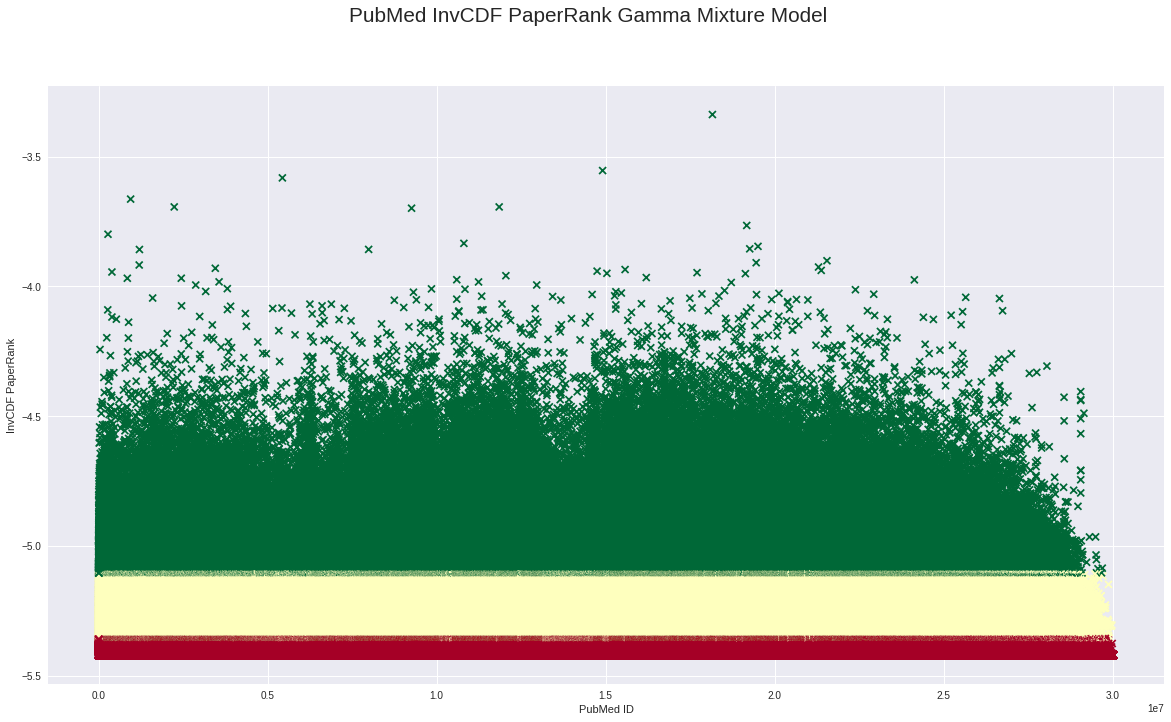

In [108]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank Gamma Mixture Model')
ax.set_xlabel('PubMed ID')
ax.set_ylabel('InvCDF PaperRank')
plt.scatter(pr_id, pr_invcdf, c=pr_gamma_classes, cmap='RdYlGn', marker='x')

## InvCDF Gamma Trust Score

In this section, we define and derive the notion of a community *trust* score.

### Baseline Trust

To correctly scale our *trust* score, we must define a level of baseline trust, $P(T)$. This represents the baseline level of trust assumed to be inherent in each of the publications, as a result of them being published in peer reviewed journals.

Being a probability distribution, $P(T)$ ranges from 0 to 1. 0 represents no trust, and 1 represents complete trust.

we set the `baseline_trust` to 0.5. That is, we assume that the baseline level of trust by being published in a peer reviewed journal is neither trusted nor untrusted.

$$
P(T) = 0.5
$$

In [0]:
gamma_baseline_trust = 0.5

### Membership Probabilities

We utilize the predicted probabilities from the [Shifted Abs Inverse CDF PaperRank Gamma Mixture Model](#scrollTo=TXTUN07LZ-th). Here, the model predicts the probability of membership in each of the clusters, given it is not in any of the other clusters. That is, it gives us:

<br>

$$
P(A_i) = P(A \cap (B \cup C)^\complement) \\
P(B_i) = P(B \cap (A \cup C)^\complement) \\
P(C_i) = P(C \cap (A \cup B)^\complement)
$$

In [0]:
p_gamma_a = pr_gamma_model.posterior[0]
p_gamma_b = pr_gamma_model.posterior[1]
p_gamma_c = pr_gamma_model.posterior[2]

### Formula Derivation

We define the probability of trust to be the probability that a given pubication, $D$ is trusted.

<br>

$$
\text{Let probability of trust for a given publication} = P(T|D)
$$

<br>

Recall Bayes' theorem:

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

Applying this to the probability of trust, $P(T|D)$, we get:

$$
P(T|D) = \frac{P(D|T)P(T)}{P(D)}
$$

We can expand the probability of the $P(D)$ into its conditional components:

$$
P(D) = P(D|T)P(T) + P(D|T^\complement)P(T^\complement) \\
\text{But,} \; P(T^\complement) = 1 - P(T) \\
\Rightarrow P(D) = P(D|T)P(T) + P(D|T^\complement)(1-P(T))
$$

Substituting this into the Bayes' theorem expansion of $P(T|D)$:

<br>

$$
\therefore \; P(T|D) = \frac{P(D|T)P(T)}{P(D|T)P(T) + P(D|T^\complement)(1-P(T))}
$$

<br>

To compute the final trust metric, $\tau$, we must scale $P(T|D)$ by the baseline probability, $P(T)$

<br>

$$
\therefore \, \tau = P(T) + P(T | D)(1 - P(T))
$$

In [0]:
def computeTrust(pr_t: np.array, pr_nt: np.array,
                 baseline_trust: np.float) -> tuple:
  """Function to compute the trust value for a given set of
  membership probabilities of trusted and untrusted publications.
  
  Arguments:
    pr_t {np.array} -- List of probabilities that a publication is trusted.
    pr_nt {np.array} -- List of probabilities that a publication is not trusted.
  
  Returns:
    {tuple} -- Tuple of type (np.array, np.array) corresponding to the scaled
               and unscaled trust respectively.
  """

  # Casting to Decimal
  baseline_trust = baseline_trust

  # Create empty array of same type and shape as pr_t
  unscaled_trust = np.empty_like(pr_t)
  trust = np.empty_like(pr_t)
  
  # Flags
  count = 0
  decile = 1
  n = len(pr_t)
  
  # Computing trust for each element (loop due to VM memory issues)
  for i in range(0, len(pr_t)):
    scaled_pr_t = pr_t[i] * baseline_trust
    scaled_pr_nt = pr_nt[i] * (1 - baseline_trust)
    unscaled_trust[i] = scaled_pr_t / (scaled_pr_t + scaled_pr_nt)
    trust[i] = baseline_trust + (unscaled_trust[i] * (1 - baseline_trust))
  
    # Logging every 10%
    if int((count * 10) / n) == 1:
      print('Trust computation {}% complete'.format(decile * 10))
      decile += 1
      count = 0
    
    count += 1
  
  return (trust, unscaled_trust)

### Trust Categories

Utilizing the probabilities predicted in the Inverse CDF transformed PaperRank, we define:

$$
\text{Let} \; P(D|T) = P(C \cap (A \cup B)^\complement)
$$

This indicates that the probability of a given publication being trusted, $P(D|T)$ is equal to the probability it is a member of the third cluster (**C**, *Highly Trusted*).

In [0]:
pr_gamma_t = p_gamma_c

Similarly, we define the probability of a given publication being not trusted, $P(D|T^\complement)$ to be the probability a publication is a member of the first (**A**, *Not Trusted*) or second cluster (**B**,  *Trusted*).

$$
\text{Let} \; P(D|T^\complement) = P((A \cup B) \cap C^\complement) \\
\text{Where} \;P((A \cup B) \cap C^\complement) = P(A \cap (B \cup C)^\complement) + P(B \cap (A \cup C)^\complement)
$$

In [0]:
pr_gamma_nt = p_gamma_a + p_gamma_b

### Trust Score Computation

In this section, we compute the trust score for each of the publications.

In [58]:
# Computing trust scores
pr_gamma_trust, pr_gamma_trust_unscaled = computeTrust(
                                            pr_t=pr_gamma_t,
                                            pr_nt=pr_gamma_nt,
                                            baseline_trust=gamma_baseline_trust)

Trust computation 10% complete
Trust computation 20% complete
Trust computation 30% complete
Trust computation 40% complete
Trust computation 50% complete
Trust computation 60% complete
Trust computation 70% complete
Trust computation 80% complete
Trust computation 90% complete


### Trust Score Scaling

To utilize the trust score in Bayesian computation, we must adjust the trust scores computed in the model above. This is to deal with the edge case scenario of publications that have a trust score equal to 1. To adjust the ranks while preserving the ordering and relative magnitude of each of the scores, we adjust the unscaled trust scores down by multiplying the entire unscaled rank vector by the highest trust score $\lt$ 1.

<br>

$$
\texttt{pr_gamma_trust_adj} = P(T) + \left( \texttt{pr_gamma_trust_unscaled} \times \text{max}_{\lt 1}(\texttt{pr_gamma_trust}) \right) (1 - P(T))
$$

In [0]:
# Getting max value strictly less than 1
max_lt1_trust = np.max(pr_gamma_trust[pr_gamma_trust < 1])

# Computing unscaled adjusted trust
pr_gamma_trust_adj_unscaled = pr_gamma_trust_unscaled * max_lt1_trust

# Computing adjusted trust
pr_gamma_trust_adj = (pr_gamma_trust_adj_unscaled * (1 - gamma_baseline_trust)) + gamma_baseline_trust

#### Trust Score Backup

In this section, we back up the trust scores and relevant probabilities.

In [80]:
# Variables to save
save_items = {
    'pr_gamma_trust': pr_gamma_trust,
    'pr_gamma_trust_unscaled': pr_gamma_trust_unscaled,
    'pr_gamma_trust_adj': pr_gamma_trust_adj,
    'pr_gamma_trust_adj_unscaled': pr_gamma_trust_adj_unscaled,
    'pr_gamma_t': pr_gamma_t,
    'pr_gamma_nt': pr_gamma_nt
}

# Saving to Google Drive
saveVariables(variables=save_items)

Trying to delete 6 files in the `models/` folder
Deleting file pr_gamma_nt with ID 1w5ElNyPZvU48_J0-atMBufU2YGdXz4WL
Deleting file pr_gamma_t with ID 1EwsFWwwedQkz68agbqTynQ4vSuSZFoiM
Deleting file pr_gamma_trust_unscaled with ID 1aVaex1YJuxDH0q49bWKDH9YAbnazVWyr
Deleting file pr_gamma_trust with ID 1PLwfSTpuGwWzhvLGsUOTVFqYdP7HPPrn
Deleted 4 files in `models/` folder
Starting variable upload
Uploading file with variable pr_gamma_trust of size 115869305
Removing temporary file of 115869305 bytes
Uploaded variable to file pr_gamma_trust with ID 1vmTz0A-HNQu5cH3SDWkPOmDnwG7tDelW
Uploading file with variable pr_gamma_trust_unscaled of size 115869305
Removing temporary file of 115869305 bytes
Uploaded variable to file pr_gamma_trust_unscaled with ID 1trhG-Tbn9pVwAzJ-f7p9vcD1yGL6HtZW
Uploading file with variable pr_gamma_trust_adj of size 115869305
Removing temporary file of 115869305 bytes
Uploaded variable to file pr_gamma_trust_adj with ID 1bYODGCVQF1RbafEVNA7rlMJpoOqK6YR2
Uploading file

#### Trust Score Export

In this section, we export the adjusted Gamma trust scores to Google Drive. See [trust score export](#scrollTo=tntMKAx2Gj1d) for more details.

In [99]:
# Creating and formatting DataFrame to be exported
pr_gamma_trust_adj_df = pd.DataFrame({'PubMed ID': pd.Series(pr_id, dtype=int),
                                      'Adj Gamma Trust': pd.Series(pr_gamma_trust_adj, dtype=np.float)})

exportTrustScore(data=pr_gamma_trust_adj_df, name='pr_gamma_trust_adj.csv')

Saving pr_gamma_trust_adj.csv to VM disk
Saved to VM disk
Uploading file with variable pr_gamma_trust_adj.csv of size 399929086
Removing temporary file of 399929086 bytes
Uploaded variable to file pr_gamma_trust_adj.csv with ID 18lF8nxCSlE6XUHinOfAzAerH68mDqpbA


### Trust Statistics

This section contains sample statistics for the adjusted trust scores.

In [65]:
pr_gamma_trust_adj_stats = computeDescriptiveStatistics(pr_gamma_trust_adj)

displayDescriptiveStatistics(stats=pr_gamma_trust_stats,
                             name='PubMed PaperRank Gamma Trust')

,PubMed PaperRank Gamma Trust
mean,5.345113e-01
sd,9.879640e-02
var,9.760729e-03
skew,3.482284e+00
kurtosis,1.148966e+01
median,5.000165e-01
min,5.000000e-01
max,1.000000e+00
range,5.000000e-01
N,1.448364e+07


### Trust Distribution Plots

This section contains plots of the InvCDF PaperRank adjusted Gamma trust score distribution.

#### Histogram

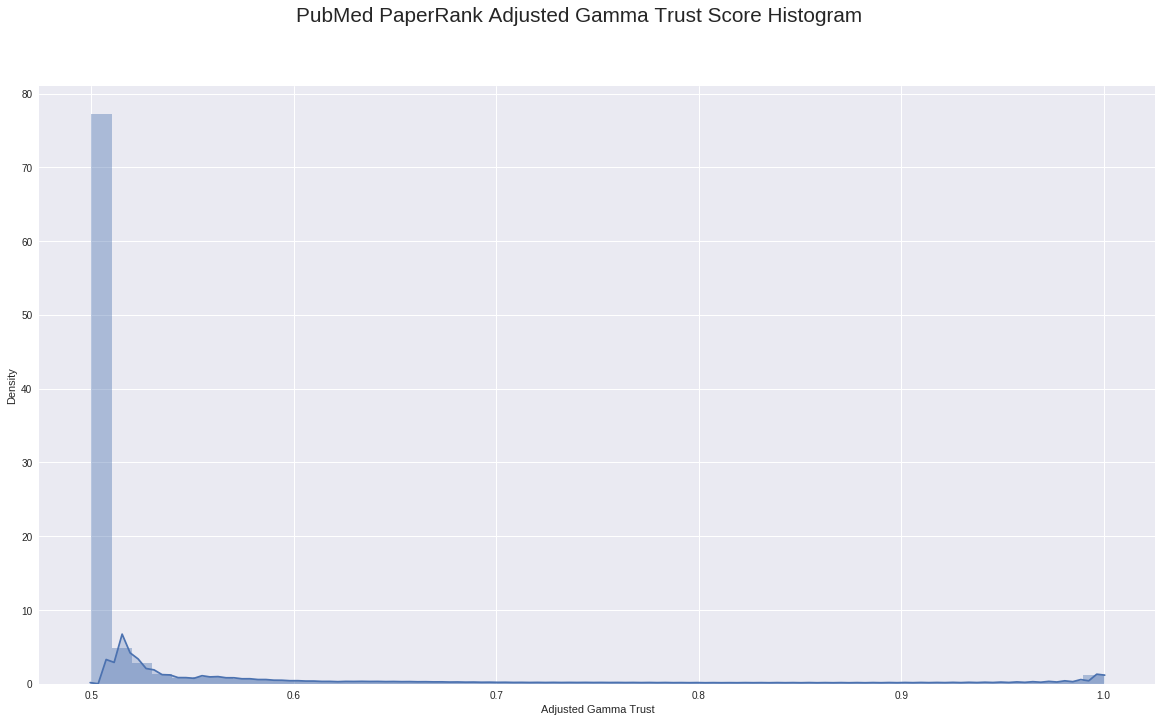

In [100]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Adjusted Gamma Trust Score Histogram')
ax.set_xlabel('Adjusted Gamma Trust')
ax.set_ylabel('Density')
sns.distplot(pr_gamma_trust_adj, kde=True, rug=False, kde_kws={'shade': True}, ax=ax)

#### Scatterplot

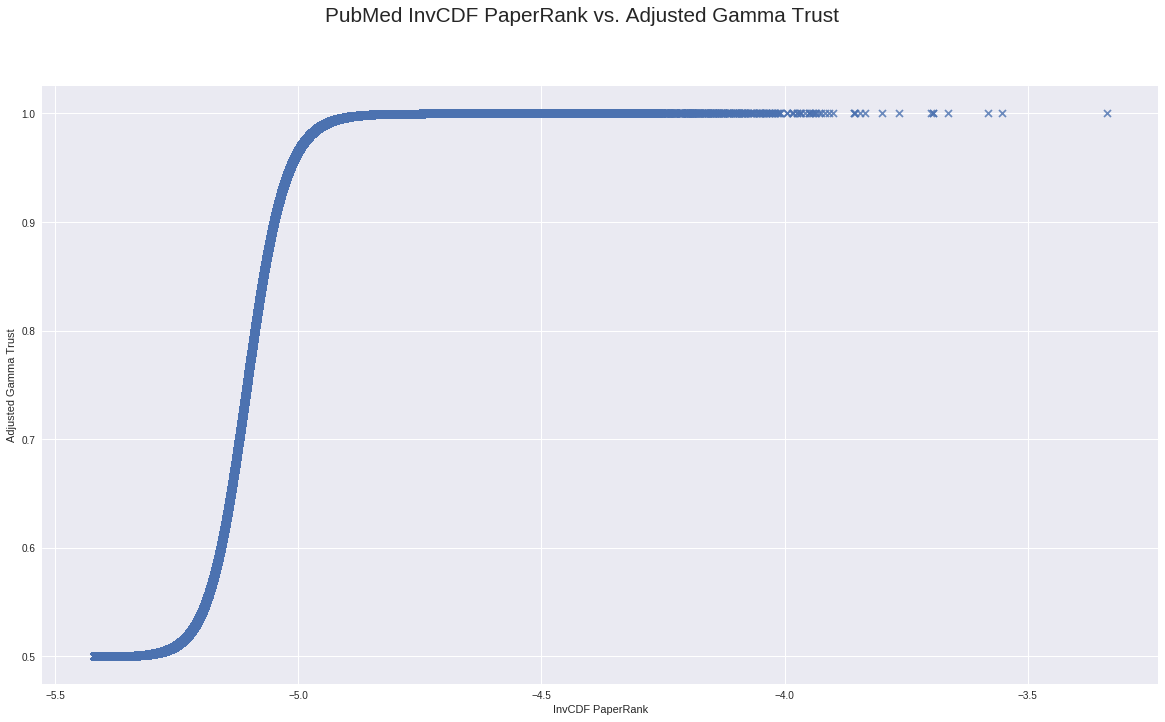

In [68]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed InvCDF PaperRank vs. Adjusted Gamma Trust')
ax.set_xlabel('InvCDF PaperRank')
ax.set_ylabel('Adjusted Gamma Trust')
sns.regplot(x=pr_invcdf, y=pr_gamma_trust_adj, fit_reg=False, ax=ax, marker='x')

## PaperRank Model Exploration

*Follow the instructions [here](#scrollTo=f3Y5KASErnH6) for this to work.*

To efficiently explore the model, this search engine allows users to query the regular PubMed search API, and plot the probability of the results being in each of the 3 categories.

Type a `search_term` and press play (or `⌘/Ctrl+Enter`).

Use the PubMed website to help construct complex queries: https://www.ncbi.nlm.nih.gov/pubmed/?term=.

To visit the website for a specific PubMed ID, append it to the end of https://www.ncbi.nlm.nih.gov/pubmed/.
  - Eg: https://www.ncbi.nlm.nih.gov/pubmed/20658405

**NOTE: The results may take a few moments to load.**

In [70]:
#@title PubMed PaperRank Model Search

search_term = 'James P McCusker' #@param {type:"string"}

# Getting search results
result_id = pubMedSearch(search_term)

# Defining result DataFrame
result = pd.DataFrame(columns=['PubMed ID', 'InvCDF PaperRank',
                               'Adj Gamma Trust', 'InvCDF Adj Gamma Trust',
                               'P(A)', 'P(B)', 'P(C)',
                               'Title', 'Authors', 'Year'])

# Defining base link
base_link = 'https://www.ncbi.nlm.nih.gov/pubmed/'

for i in range(len(result_id)):
  # Isolating current ID
  current_id = result_id[i]

  try:
    # Getting MetaData
    metadata = getPublicationMetadata(str(current_id))

   # Getting prediction index
    idx = np.where(current_id == pr_id)[0][0]
  except:
    # Skip if not found
    continue
  
  # Adding to result
  rowdata = [current_id, pr_invcdf[idx],
             pr_gamma_trust_adj[idx], norm.ppf(pr_gamma_trust_adj[idx]),
             pr_gamma_model.posterior[0][idx],
             pr_gamma_model.posterior[1][idx],
             pr_gamma_model.posterior[2][idx],
             metadata[0], metadata[1], metadata[2]]
  
  result.loc[i] = rowdata

# Changing Pandas display settings to show full table
pd.set_option('max_colwidth', 1000)
pd.set_option('expand_frame_repr', True)

# Rounding
decimals = pd.Series([5, 10, 5, 5, 5], index=['InvCDF PaperRank',
                                              'Adj Gamma Trust',
                                              'P(A)', 'P(B)', 'P(C)'])

# Displaying table
display(HTML(result.round(decimals).to_html(index=False)))

# Reset Pandas settings
pd.reset_option('max_colwidth')
pd.reset_option('expand_frame_repr')

PubMed ID,InvCDF PaperRank,Adj Gamma Trust,InvCDF Adj Gamma Trust,P(A),P(B),P(C),Title,Authors,Year
26214590,-4.93085,0.993059,2.460282e+00,0.00000,0.01388,0.98612,Exome sequencing identifies recurrent mutations in NF1 and RASopathy genes in sun-exposed melanomas.,"Krauthammer M, Kong Y, Bacchiocchi A, Evans P, Pornputtapong N, Wu C, McCusker JP, Ma S, Cheng E, Straub R, Serin M, Bosenberg M, Ariyan S, Narayan D, Sznol M, Kluger HM, Mane S, Schlessinger J, Lifton RP, Halaban R",2015
24602174,-5.06279,0.873117,1.141249e+00,0.00000,0.25377,0.74623,The Semanticscience Integrated Ontology (SIO) for biomedical research and knowledge discovery.,"Dumontier M, Baker CJ, Baran J, Callahan A, Chepelev L, Cruz-Toledo J, Del Rio NR, Duck G, Furlong LI, Keath N, Klassen D, McCusker JP, Queralt-Rosinach N, Samwald M, Villanueva-Rosales N, Wilkinson MD, Hoehndorf R",2014
27631029,-5.40977,0.500000,2.396842e-09,0.99993,0.00007,0.00000,"Next Generation Cancer Data Discovery, Access, and Integration Using Prizms and Nanopublications.","McCusker JP, Lebo T, Krauthammer M, McGuinness DL",2013
22842228,-4.65940,0.999986,4.195318e+00,0.00000,0.00003,0.99997,Exome sequencing identifies recurrent somatic RAC1 mutations in melanoma.,"Krauthammer M, Kong Y, Ha BH, Evans P, Bacchiocchi A, McCusker JP, Cheng E, Davis MJ, Goh G, Choi M, Ariyan S, Narayan D, Dutton-Regester K, Capatana A, Holman EC, Bosenberg M, Sznol M, Kluger HM, Brash DE, Stern DF, Materin MA, Lo RS, Mane S, Ma S, Kidd KK, Hayward NK, Lifton RP, Schlessinger J, Boggon TJ, Halaban R",2012
22373303,-5.40046,0.500000,6.693307e-08,0.99911,0.00089,0.00000,A semantic web framework to integrate cancer omics data with biological knowledge.,"Holford ME, McCusker JP, Cheung KH, Krauthammer M",2012
21624155,-5.15304,0.614771,2.917749e-01,0.00000,0.77046,0.22954,The Translational Medicine Ontology and Knowledge Base: driving personalized medicine by bridging the gap between bench and bedside.,"Luciano JS, Andersson B, Batchelor C, Bodenreider O, Clark T, Denney CK, Domarew C, Gambet T, Harland L, Jentzsch A, Kashyap V, Kos P, Kozlovsky J, Lebo T, Marshall SM, McCusker JP, McGuinness DL, Ogbuji C, Pichler E, Powers RL, Prud'hommeaux E, Samwald M, Schriml L, Tonellato PJ, Whetzel PL, Zhao J, Stephens S, Dumontier M",2011
20149136,-4.82639,0.999387,3.232746e+00,0.00000,0.00123,0.99877,"PLX4032, a selective BRAF(V600E) kinase inhibitor, activates the ERK pathway and enhances cell migration and proliferation of BRAF melanoma cells.","Halaban R, Zhang W, Bacchiocchi A, Cheng E, Parisi F, Ariyan S, Krauthammer M, McCusker JP, Kluger Y, Sznol M",2010
19796399,-5.23233,0.516778,4.206900e-02,0.00002,0.96642,0.03356,Semantic web data warehousing for caGrid.,"McCusker JP, Phillips JA, González Beltrán A, Finkelstein A, Krauthammer M",2009
